# FooLS - Fooling LIME and SHAP Framework
This work is based on Dylan et al. who have proven that perturbation-based post-hoc explanation methods (in particular LIME and SHAP) are not reliable since an adversary could create a model that is extremely biased but will nonetheless be regarded as unbiased if explained by perturbation-based post-hoc explanation. Dylan et al. have proposed an approach that makes it possible to create a new adversarial model which succesfully hides the bias of a model when LIME or SHAP are applied on it, respectively. Our framework allows it to easily create these adversarial models on the fly. In Addition to that we have also examined the influence of the different parameters and perturbation methods on LIME and SHAP. We have also added three new datasets to evaluate these methods.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from adversarial_models import * 
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, get_dataset, info_plots

from sklearn.cluster import Birch
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

## Partical Dependence Plots
We have extended the framework by PDP but have been unable to fool PDP. However, in theory this should be possible since PDP also uses perturbations when fixing all non-interested features and changing the feature(s) of interest. There are other approaches that claim to have successfully fooled PDP by data poisening ("Fooling Partial Dependence via Data Poisoning", Baniecki et al.)

In [2]:
class PDP:
    @staticmethod
    def calculate_ice(model, X, s):
        """
        Takes the input data and expands the dimensions from (num_instances, num_features) to (num_instances,
        num_instances, num_features). For the current instance i and the selected feature index s, the
        following equation is ensured: X_ice[i, :, s] == X[i, s].

        Parameters:
            model: Classifier which can call a predict method.
            X (np.array with shape (num_instances, num_features)): Input data.
            s (int): Index of the feature x_s.

        Returns:
            X_ice (np.array with shape (num_instances, num_instances, num_features)): Changed input data w.r.t. x_s.
            y_ice (np.array with shape (num_instances, num_instances)): Predicted data.
        """
        num_instances = len(X)
        num_features = len(X[0])
        unique_values_s = X[:,s]
        X_ice = np.empty((num_instances, num_instances, num_features))
        for i in range(0, num_instances):
            for j in range(0, num_instances):
                X_ice[i][j] = X[i]
                for k in range(0, num_features):
                    if k != s:
                        X_ice[i][j][k] = X[j][k]
        y_ice = np.empty((num_instances, num_instances))
        for i in range(0, num_instances):
            y_ice[i] = model.predict(X_ice[i])
        return X_ice, y_ice

    @staticmethod
    def prepare_ice(model, X, s, centered=False):
        """
        Uses `calculate_ice` to retrieve plot data.

        Parameters:
            model: Classifier which can call a predict method.
            X (np.array with shape (num_instances, num_features)): Input data.
            s (int): Index of the feature x_s.
            centered (bool): Whether c-ICE should be used or not.

        Returns:
            all_x (list or 1D np.ndarray): List of lists of the x values.
            all_y (list or 1D np.ndarray): List of lists of the y values.
                Each entry in `all_x` and `all_y` represents one line in the plot.
        """
        num_instances = len(X)
        X_ice, all_y = PDP.calculate_ice(model, X, s)
        all_y = all_y.transpose()
        all_x = np.empty((num_instances, num_instances))
        for i in range(num_instances):
            for j in range(num_instances):
                all_x[i][j] = X_ice[i][j][s]
        all_x = all_x.transpose()
        for i in range(num_instances):
            all_x[i], all_y[i] = zip(*sorted(zip(all_x[i], all_y[i])))
        if centered == True:
            for i in range(num_instances):
                center_value = all_y[i][0]
                for j in range(num_instances):
                    all_y[i][j] = all_y[i][j] - center_value
        return all_x, all_y

    @staticmethod
    def plot_ice(model, dataset, X, s, centered=False):
        """
        Creates a plot object and fills it with the content of `prepare_ice`.
        Note: `show` method is not called.

        Parameters:
            model: Classifier which can call a predict method.
            dataset (utils.Dataset): Used dataset to train the model. Used to receive the labels.
            s (int): Index of the feature x_s.
            centered (bool): Whether c-ICE should be used or not.

        Returns:
            plt (matplotlib.pyplot or utils.styled_plot.plt)
        """
        plt.figure()
        all_x, all_y = PDP.prepare_ice(model, X, s, centered)
        plt.plot(all_x, all_y, alpha=0.2)
        x_label = dataset.get_input_labels()[s]
        y_label = dataset.get_output_label()
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        return plt

    @staticmethod
    def prepare_pdp(model, X, s):
        """
        Uses `calculate_ice` to retrieve plot data for PDP.

        Parameters:
            model: Classifier which can call a predict method.
            X (np.ndarray with shape (num_instances, num_features)): Input data.
            s (int): Index of the feature x_s.

        Returns:
            x (list or 1D np.ndarray): x values of the PDP line.
            y (list or 1D np.ndarray): y values of the PDP line.
        """
        x = []
        y = []
        num_instances = len(X)
        X_ice, y_ice = PDP.calculate_ice(model, X, s)
        for i in range(num_instances):
            x.append(X_ice[i][i][s])
            sum = 0
            for j in range(num_instances):
                sum += y_ice[i,j]
            y.append(sum/num_instances)
        x, y = zip(*sorted(zip(x, y)))
        x = np.asarray(x)
        y = np.asarray(y)
        return x, y

    @staticmethod
    def plot_pdp(model, X, s):
        """
        Creates a plot object and fills it with the content of `prepare_pdp`.
        Note: `show` method is not called.

        Parameters:
            model: Classifier which can call a predict method.
            dataset (utils.Dataset): Used dataset to train the model. Used to receive the labels.
            s (int): Index of the feature x_s.
            centered (bool): Whether c-ICE should be used or not.

        Returns:
            plt (matplotlib.pyplot or utils.styled_plot.plt)
        """
        plt.figure()

        x, y = PDP.prepare_pdp(model, X, s)
        plt.plot(x, y)
        return plt

    @staticmethod
    def plot_pdp_all(model, X, feature_names):
        """
        Creates a plot object and fills it with the content of `prepare_pdp`.
        Note: `show` method is not called.

        Parameters:
            model: Classifier which can call a predict method.
            dataset (utils.Dataset): Used dataset to train the model. Used to receive the labels.
            s (int): Index of the feature x_s.
            centered (bool): Whether c-ICE should be used or not.

        Returns:
            plt (matplotlib.pyplot or utils.styled_plot.plt)
        """
        plt.figure()
        fig, ax = plt.subplots(nrows=3, ncols=5)
        fig.set_size_inches(18.5, 10.5)
        s = range(X.shape[1])
        i = 0
        for row in ax:
            for col in row:
                if i < X.shape[1]:
                    x, y = PDP.prepare_pdp(model, X, s[i])
                    col.plot(x, y)
                    col.set_xlabel(list(feature_names.keys())[list(feature_names.values()).index(i)])
                    i +=1

        return plt


## FooLS Framework

In [3]:
#Constants that are used distinguish between the different modes of our framework
METHOD_LIME = 0
METHOD_SHAP = 1
ONE_EXISTING_COLUMN = 0
ONE_UNCORRELATED_COLUMN = 1
TWO_UNCORRELATED_COLUMN = 2
#The framework class that takes in certain parameters and provides functions to generate adversarial models 
#which can fool LIME and SHAP, respectively. It also provides a function that plots the PDP. 
class FooLS:
    def __init__(self, protected_class_name, protected_class_name_value, unprotected_class_name, unprotected_class_name_value, column_flag, pd_dataset, categorical_feature_names=[], correlated_column=None, seed=None, perturbation_lime_mode=PERTURB_LIME_MODE_STD, perturbation_shap_mode=PERTURB_SHAP_MODE_STD, unrelated_column1_name='unrelated_column1', unrelated_column2_name='unrelated_column2'):
        """
        Initializes a FooLS object which can be used to create adversarial models that fool LIME and SHAP.
        Also, a PDP function is provided by this class

        Parameters:
            protected_class_name (str): The name of the feature/class that the discriminatory model uses to make its decision and which should be hidden (e.g. 'race')
            protected_class_name_value (list): A list of values which should be treated as the reason for making the discriminatory decisions (e.g. ['black', 'hispanic'])
            unprotected_class_name (str): The name of the feature/class that is the y-value.
            unprotected_class_name_value (list): A List of values which should lead to a positive outcome in the y-value.
            column_flag (int): The flag that decides if the bias should be shifted towards another existing column, a new uncorrelated column, or two new uncorrelated columns
            pd_dataset (pandas.Dataframe): Panda dataframe of the used dataset.
            categorical_feature_names (list): List of names of features/classes that are categorical (e.g. (0,1), (HIGH, LOW)).
            correlated_column (str): If you want to use an existing feature/class then you need to pass the name of that column to this function.
            seed (int): numpy seed to fix randomness.
            perturbation_lime_mode (int): Set the perturbation technique that should be used to generate OOD samples (standard, soft brownian offset, gaussian hypersperic offset).
            perturbation_shap_mode (int): Set the perturbation technique that should be used to generate the background perturbation (standard, birch).
            unrelated_column1_name (str): Name of the new uncorrelated feature/class that will be added to the dataset if the corresponding mode is chosen.
            unrelated_column2_name (str): Name of the new uncorrelated feature/class that will be added to the dataset if the corresponding mode is chosen.
        """
        if column_flag == ONE_EXISTING_COLUMN and correlated_column == None:
            raise Exception("You need to provide a column name if you want to shift importance\
                            to an existing feature.")
        if not isinstance(pd_dataset, pd.DataFrame):
            raise Exception("The dataset needs to be a Pandas Dataframe.")
        if correlated_column is not None and correlated_column not in pd_dataset.columns:
            raise Exception("You need to provide an existing column that is part of the dataset if you want to use\
                            an existing feature")
        if column_flag not in [ONE_EXISTING_COLUMN,ONE_UNCORRELATED_COLUMN,TWO_UNCORRELATED_COLUMN]:
            raise Exception("Only three modes available: Use an existing feature, a new uncorrelated feature,\
                            or two new uncorrelated features.")
        if perturbation_lime_mode not in [0,1,2] or perturbation_shap_mode not in [0,1]:
            raise Exception("Only three perturbation methods available for each LIME and SHAP.")
        if not isinstance(protected_class_name, str) or not isinstance(unprotected_class_name, str):
            raise Exception("You need to provide the names of the protected and unprotected features.")
        if not isinstance(protected_class_name_value, list) or not isinstance(unprotected_class_name_value, list):
            raise Exception("You need to provide the values of the bias-prone feature which should lead to\
                            discrimination and the values of the non-bias-prone feature which would lead to\
                            a fair classification.")
        
        self.seed = np.random.randint(0xffffffff) if seed == None else seed
        self.protected_class_name = protected_class_name
        self.protected_class_name_value = protected_class_name_value
        self.unprotected_class_name = unprotected_class_name
        self.unprotected_class_name_value = unprotected_class_name_value
        self.column_flag = column_flag
        self.correlated_column = correlated_column
        self.categorical_feature_names = categorical_feature_names
        self.pd_dataset = pd_dataset
        self.unrelated_column1_name = unrelated_column1_name
        self.unrelated_column2_name = unrelated_column2_name
        self.perturbation_lime_mode = perturbation_lime_mode
        self.perturbation_shap_mode = perturbation_shap_mode
        
        np.random.seed(self.seed)
        self.setup()
    #We expect that NAs or other undesireble entries have been removed
    #protected class is the class that the discriminatoy model should use to classify (e.g race).
    #unprotected class is the class that is used as a label (e.g credit score class).
    #For both classes we iterate through the given (un)protected_class_name_values and replace the value of the columns with 1 if it is part of those classes or 0 if it is not
    #example: column 'race' is the protected class and protected_class_name_values is a list of ['African', 'Hispanic']. All race column entries are now either replaced by 1 if that entry is African or Hispanic or 0 if its not
    def preprocess_data(self):
        X = self.pd_dataset
        y = np.array([1 if val in self.unprotected_class_name_value else 0 for val in X[self.unprotected_class_name]])
        X = X.drop(self.unprotected_class_name, axis=1)
        sens = X.pop(self.protected_class_name)
        X = pd.get_dummies(X)
        buffer = [np.array(pd.get_dummies(sens).pop(x)) for x in self.protected_class_name_value]
        sensitive_attr = np.array([0]*len(sens))
        for attr in buffer:
            sensitive_attr = sensitive_attr + attr
        X[self.protected_class_name] = sensitive_attr
        return X, y
    #Here we create either unrelated columns that are used to explain our discriminatoy model
    #or we use an existing feature column_flag
    #ONE_EXISTING_COLUMN := use existing feature (needs 'correlated_column' to be set)
    #ONE_UNCORRELATED_COLUMN := 1 unrelated column
    #TWO_UNCORRELATED_COLUMN := 2 unrelated columns
    def setup(self):
        X, y = self.preprocess_data()
        self.unrelated_indcs = []
        self.X, self.y = X,y
        
        if self.column_flag == ONE_EXISTING_COLUMN:
            self.unrelated_indcs.append(X.columns.get_loc(self.correlated_column))
            if self.correlated_column not in self.categorical_feature_names:
                self.categorical_feature_names.append(self.correlated_column)
        elif self.column_flag == ONE_UNCORRELATED_COLUMN:
            X[self.unrelated_column1_name] = np.random.choice([0,1],size=X.shape[0])
            self.unrelated_indcs.append(X.columns.get_loc(self.unrelated_column1_name))
            self.categorical_feature_names.append(self.unrelated_column1_name)
        elif self.column_flag == TWO_UNCORRELATED_COLUMN:
            X[self.unrelated_column1_name] = np.random.choice([0,1],size=X.shape[0])
            self.unrelated_indcs.append(X.columns.get_loc(self.unrelated_column1_name))
            X[self.unrelated_column2_name] = np.random.choice([0,1],size=X.shape[0])
            self.unrelated_indcs.append(X.columns.get_loc(self.unrelated_column2_name))
            self.categorical_feature_names.append(self.unrelated_column1_name)
            self.categorical_feature_names.append(self.unrelated_column2_name)
        
        #Save the feature column names
        self.features = [c for c in X]
        self.protected_indc = self.features.index(self.protected_class_name)
        
        #String data will be split into n different columns with one-hot encoding
        #example: column 'sex' can either have value 'male' or 'female'. That column will be split up into two columns 'sex_male' and 'sex_female' which contain value 0 if an entry is not of that specific class or 1 if it is
        new_categorical_feature_names = []
        for cat in self.categorical_feature_names:
            if cat not in X.columns.tolist():
                new_categorical_feature_names += [col for col in X.columns.tolist() if col.startswith(cat+'_')]
            else:
                new_categorical_feature_names.append(cat)
        self.categorical_feature_names = new_categorical_feature_names
        
        #Convert pandas dataframe to numpy array
        X = X.values
        #extract the indeces of the categorical feature columns
        self.categorical_feature_indcs = [self.features.index(c) for c in self.categorical_feature_names]
        
        # Split the data and normalize
        self.xtrain ,self.xtest ,self.ytrain ,self.ytest = train_test_split(X,y)
        xtest_not_normalized = deepcopy(self.xtest)
        ss = StandardScaler().fit(self.xtrain)
        self.xtrain = ss.transform(self.xtrain)
        self.xtest = ss.transform(self.xtest)
        
    class discriminatory_model:
        def __init__(self, protected_indc):
            self.protected_indc = protected_indc
        def predict(self,X):
            #Since we normalize between -1 and 1 the 'True' and 'False'
            #values will always be bigger or smaller than 0, respectively
            return np.array([0 if x[self.protected_indc] > 0 else 1 for x in X])

        def predict_proba(self, X): 
            return one_hot_encode(self.predict(X))

        def score(self, X,y):
            return np.sum(self.predict(X)==y) / len(X)
    
    class innocuous_model_psi:
        def __init__(self, unrelated_indcs):
            self.unrelated_indcs = unrelated_indcs
        #Since we normalize between -1 and 1 the 'True' and 'False'
        #values will always be bigger or smaller than 0, respectively
        def predict(self,X):
            return np.array([0 if x[self.unrelated_indcs[0]] > 0 else 1 for x in X])

        def predict_proba(self, X): 
            return one_hot_encode(self.predict(X))

        def score(self, X,y):
            return np.sum(self.predict(X)==y) / len(X)
    
    class innocuous_model_psi_two:
        def __init__(self, unrelated_indcs):
            self.unrelated_indcs = unrelated_indcs
        #When using two new uncorrelated features then the prediction is the xor of each feature entry
        def predict_proba(self, X):
            A = np.where(X[:,self.unrelated_indcs[0]] > 0, 1, 0)
            B = np.where(X[:,self.unrelated_indcs[1]] > 0, 1, 0)
            preds = np.logical_xor(A, B).astype(int)
            return one_hot_encode(preds)
    
    def LIME_execute(self, sample_around_instance=True, discretize_continuous=False, perturbation_std=0.3, perturbation_multiplier=30, rf_estimators=100, verbose=True):
        """
        Create the adversarial model that fools LIME by replacing the biased model with a model that
        distinguishes between out-of-distribution samples and inside-distribution samples which still
        leads to the same prediction but different explanation.

        Parameters:
            sample_around_instance (bool)
            discretize_continuous (bool)
            perturbation_std (float)
            perturbation_multiplier (float)
            rf_estimators (int)
            verbose (bool)
        """
        if self.column_flag == ONE_EXISTING_COLUMN or self.column_flag == ONE_UNCORRELATED_COLUMN:
            #Create the adversarial LIME model
            adv_lime = Adversarial_Lime_Model(self.discriminatory_model(self.protected_indc), self.innocuous_model_psi(self.unrelated_indcs), perturbation_std=perturbation_std).train(self.xtrain, self.ytrain, categorical_features=self.categorical_feature_indcs, feature_names=self.features, perturbation_multiplier=perturbation_multiplier, rf_estimators=rf_estimators, perturbation_mode=self.perturbation_lime_mode)
            #Explain the newly created adversarial LIME model
            adv_explainer = lime.lime_tabular.LimeTabularExplainer(self.xtrain, sample_around_instance=sample_around_instance, feature_names=adv_lime.get_column_names(), categorical_features=self.categorical_feature_indcs, discretize_continuous=discretize_continuous)

            #Extract the explanations from the explainer
            explanations = []
            for i in range(self.xtest.shape[0]):
                explanations.append(adv_explainer.explain_instance(self.xtest[i], adv_lime.predict_proba).as_list())

            if verbose == True:
                # Display Results
                print ("LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:")
                print (experiment_summary(explanations, self.features))
                print ("Fidelity:", round(adv_lime.fidelity(self.xtest),2))

        if self.column_flag == TWO_UNCORRELATED_COLUMN:
            #Same as above with the difference that we use two new uncorrelated features
            adv_lime = Adversarial_Lime_Model(self.discriminatory_model(self.protected_indc), self.innocuous_model_psi_two(self.unrelated_indcs), perturbation_std=perturbation_std).train(self.xtrain, self.ytrain, categorical_features=self.categorical_feature_indcs, feature_names=self.features, perturbation_multiplier=perturbation_multiplier, rf_estimators=rf_estimators, perturbation_mode=self.perturbation_lime_mode)
            adv_explainer = lime.lime_tabular.LimeTabularExplainer(self.xtrain, feature_names=adv_lime.get_column_names(), categorical_features=self.categorical_feature_indcs, discretize_continuous=discretize_continuous)
            
            explanations = []
            for i in range(self.xtest.shape[0]):
                explanations.append(adv_explainer.explain_instance(self.xtest[i], adv_lime.predict_proba).as_list())

            if verbose == True:
                print ("LIME Ranks and Pct Occurances two unrelated features:")
                print (experiment_summary(explanations, self.features))
                print ("Fidelity:", round(adv_lime.fidelity(self.xtest),2))
            
        return adv_lime, experiment_summary(explanations, self.features)
        
    def SHAP_execute(self, cluster=10, perturbation_multiplier=30, rf_estimators=100, verbose=True):
        """
        Create the adversarial model that fools SHAP by replacing the biased model with a model that
        distinguishes between out-of-distribution samples and inside-distribution samples which still
        leads to the same prediction but different explanation.

        Parameters:
            cluster (int)
            perturbation_multiplier (int)
            rf_estimators (int)
            verbose (bool)
        """

        if self.column_flag == ONE_EXISTING_COLUMN or self.column_flag == ONE_UNCORRELATED_COLUMN:
            #Depending on the perturbation mode create a different background perturbation
            if self.perturbation_shap_mode == PERTURB_SHAP_MODE_STD:
                background_distribution = shap.kmeans(self.xtrain,cluster)
            elif self.perturbation_shap_mode == PERTURB_SHAP_MODE_BIRCH:
                birch = Birch().fit(self.xtrain)
                background_distribution = birch.subcluster_centers_[:cluster]
            #Create an adversarial model that can fool SHAP
            adv_shap = Adversarial_Kernel_SHAP_Model(self.discriminatory_model(self.protected_indc), self.innocuous_model_psi(self.unrelated_indcs)).train(self.xtrain, self.ytrain, feature_names=self.features, n_kmeans=cluster, perturbation_multiplier=perturbation_multiplier, rf_estimators=rf_estimators, perturbation_mode=self.perturbation_shap_mode)
            #Explain the adversarial model which leads to the explanation that hides the bias
            adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
            explanations = adv_kerenel_explainer.shap_values(self.xtest)

            formatted_explanations = []
            for exp in explanations:
                formatted_explanations.append([(self.features[i], exp[i]) for i in range(len(exp))])

            if verbose == True:
                print ("SHAP Ranks and Pct Occurances one unrelated features:")
                print (experiment_summary(formatted_explanations, self.features))
                print ("Fidelity:",round(adv_shap.fidelity(self.xtest),2))
                print ('---------------------')

        if self.column_flag == TWO_UNCORRELATED_COLUMN:
            #Same as above with the difference that we use two new uncorrelated features
            if self.perturbation_shap_mode == PERTURB_SHAP_MODE_STD:
                background_distribution = shap.kmeans(self.xtrain,cluster)
            elif self.perturbation_shap_mode == PERTURB_SHAP_MODE_BIRCH:
                birch = Birch().fit(self.xtrain)
                background_distribution = birch.subcluster_centers_[:cluster]
            
            adv_shap = Adversarial_Kernel_SHAP_Model(self.discriminatory_model(self.protected_indc), self.innocuous_model_psi_two(self.unrelated_indcs)).train(self.xtrain, self.ytrain, feature_names=self.features, n_kmeans=cluster, perturbation_multiplier=perturbation_multiplier, rf_estimators=rf_estimators, perturbation_mode=self.perturbation_lime_mode)
            adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
            explanations = adv_kerenel_explainer.shap_values(self.xtest)

            formatted_explanations = []
            for exp in explanations:
                formatted_explanations.append([(self.features[i], exp[i]) for i in range(len(exp))])

            if verbose == True:
                print ("SHAP Ranks and Pct Occurances two unrelated features:")
                print (experiment_summary(formatted_explanations, self.features))
                print ("Fidelity:",round(adv_shap.fidelity(self.xtest),2))
                print ('---------------------')

        #Get a bar-plot for better visualization
        if verbose == True:
            shap.summary_plot(explanations, feature_names=self.features, plot_type="bar")
        
        return adv_shap, experiment_summary(formatted_explanations, self.features)
            
    def PDP_execute(self, fool_method=METHOD_LIME):
        """
        Create the Partical Dependence Plot that shows feature importance of each feature.

        Parameters:
            fool_method (int)
        """
        #Depending on the chosen mode either apply PDP on the adversarial
        #LIME or SHAP model
        if fool_method == METHOD_LIME:
            adv_model, _ = self.LIME_execute(verbose=False)
        elif fool_method == METHOD_SHAP:
            adv_model, _ = self.SHAP_execute(verbose=False)
        #Create name and index dictionary to label PDP
        lista = list(self.features)
        names = {}
        for i in range(len(self.features)):
            names[lista[i]] = i
        if fool_method == METHOD_LIME:
            print("PDP plot using the adversarial LIME model")
        elif fool_method == METHOD_SHAP:
            print("PDP plot using the adversarial SHAP model")
        PDP.plot_pdp_all(adv_model, self.xtest, names)

## COMPAS Dataset
Check if our Framework gets similar results on the datasets provided in the paper - it does!

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007777057679844459), ('c_charge_degree_F', 0.13609850939727802), ('c_charge_degree_M', 0.12637718729747247), ('length_of_stay', 0.005832793259883344), ('priors_count', 0.011665586519766688), ('race', 0.2663642255346727), ('sex_Female', 0.13998703823720027), ('sex_Male', 0.17563188593648738), ('two_year_recid', 0.13026571613739468)], 3: [('age', 0.012313674659753726), ('c_charge_degree_F', 0.14970836033700582), ('c_charge_degree_M', 0.15035644847699287), ('length_of_stay', 0.02138690861957226), ('priors_count', 0.016202203499675955), ('race', 0.24627349319507452), ('sex_Female', 0.11211924821775761), ('sex_Male', 0.10758263123784835), ('two_year_recid', 0.18405703175631885)]}
Fidelity: 0.99


  0%|          | 0/1543 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('age', 0.002592352559948153), ('length_of_stay', 0.01814646791963707), ('race', 0.0006480881399870382), ('unrelated_column1', 0.9786130913804277)], 2: [('Nothing shown', 0.004536616979909268), ('age', 0.0965651328580687), ('c_charge_degree_F', 0.0006480881399870382), ('length_of_stay', 0.2572909915748542), ('priors_count', 0.056383668178872325), ('race', 0.5476344782890473), ('sex_Male', 0.0019442644199611147), ('two_year_recid', 0.013609850939727802), ('unrelated_column1', 0.02138690861957226)], 3: [('Nothing shown', 0.004536616979909268), ('age', 0.21710952689565782), ('c_charge_degree_F', 0.0032404406999351912), ('c_charge_degree_M', 0.0032404406999351912), ('length_of_stay', 0.338950097213221), ('priors_count', 0.18664938431626701), ('race', 0.19053791315618923), ('sex_Female', 0.008425145819831496), ('sex_Male', 0.014257939079714841), ('two_year_recid', 0.03305249513933895)]}
Fidelity: 0.91
---------------------


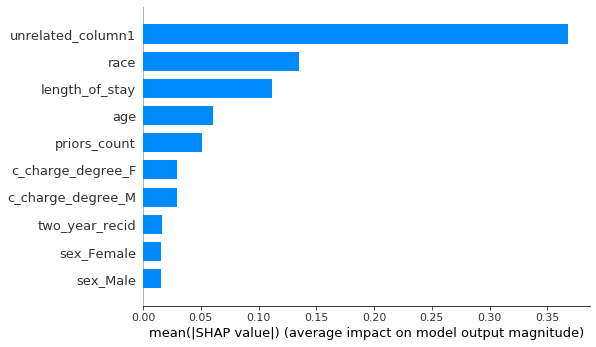

  0%|          | 0/1543 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

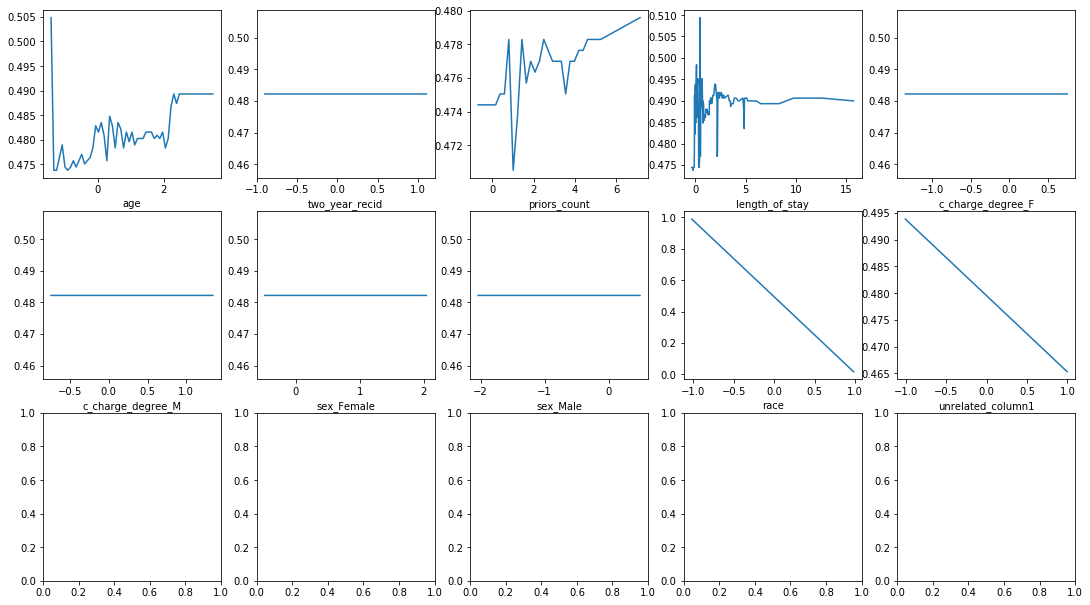

<Figure size 432x288 with 0 Axes>

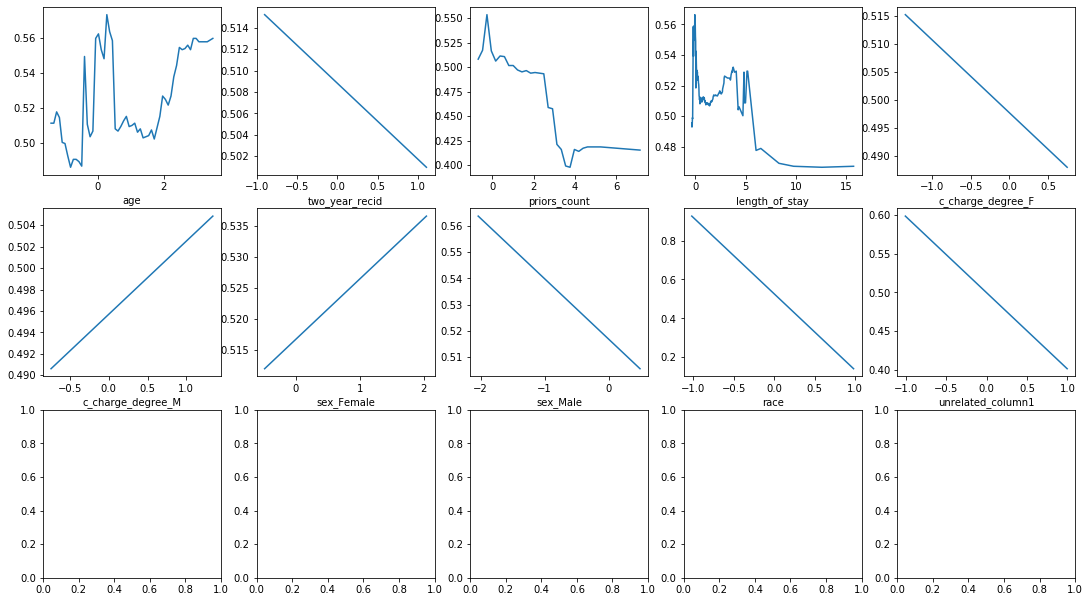

In [122]:
compas_df = pd.read_csv("data/compas-scores-two-years.csv", index_col=0)
compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
            (compas_df['days_b_screening_arrest'] >= -30) &
            (compas_df['is_recid'] != -1) &
            (compas_df['c_charge_degree'] != "O") &
            (compas_df['score_text'] != "NA")]
compas_df['length_of_stay'] = (pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days
dataset = compas_df[['age', 'two_year_recid','c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay', 'score_text']]

fools = FooLS(protected_class_name='race', protected_class_name_value=['African-American'], unprotected_class_name='score_text', unprotected_class_name_value=['High'], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['two_year_recid', 'c_charge_degree', 'sex', 'race'], pd_dataset=dataset)
_,_ = fools.LIME_execute()
_,_ = fools.SHAP_execute()
fools.PDP_execute(fool_method=METHOD_LIME)
fools.PDP_execute(fool_method=METHOD_SHAP)

## German Loan Dataset
Check if our Framework gets similar results on the datasets provided in the paper - it does!

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('LoanRateAsPercentOfIncome', 1.0)], 2: [('CheckingAccountBalance_geq_0', 0.012), ('CheckingAccountBalance_geq_200', 0.068), ('CriticalAccountOrLoansElsewhere', 0.06), ('ForeignWorker', 0.116), ('Gender', 0.02), ('HasCoapplicant', 0.092), ('HasGuarantor', 0.072), ('HasTelephone', 0.02), ('JobClassIsSkilled', 0.028), ('MissedPayments', 0.096), ('NoCurrentLoan', 0.064), ('OtherLoansAtBank', 0.06), ('OwnsHouse', 0.004), ('RentsHouse', 0.048), ('SavingsAccountBalance_geq_100', 0.028), ('SavingsAccountBalance_geq_500', 0.068), ('Single', 0.008), ('Unemployed', 0.06), ('YearsAtCurrentJob_geq_4', 0.02), ('YearsAtCurrentJob_lt_1', 0.056)], 3: [('CheckingAccountBalance_geq_0', 0.064), ('CheckingAccountBalance_geq_200', 0.052), ('CriticalAccountOrLoansElsewhere', 0.04), ('ForeignWorker', 0.072), ('Gender', 0.048), ('HasCoapplicant', 0.048), ('HasGuarantor', 0.064), ('HasTelephone', 0.044), ('J

  0%|          | 0/250 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Age', 0.016), ('CheckingAccountBalance_geq_0', 0.024), ('CriticalAccountOrLoansElsewhere', 0.032), ('ForeignWorker', 0.008), ('Gender', 0.08), ('HasGuarantor', 0.004), ('HasTelephone', 0.024), ('JobClassIsSkilled', 0.012), ('LoanAmount', 0.056), ('LoanDuration', 0.056), ('LoanRateAsPercentOfIncome', 0.408), ('NoCurrentLoan', 0.008), ('Nothing shown', 0.144), ('NumberOfOtherLoansAtBank', 0.008), ('OtherLoansAtBank', 0.016), ('RentsHouse', 0.004), ('SavingsAccountBalance_geq_100', 0.004), ('Single', 0.012), ('Unemployed', 0.008), ('YearsAtCurrentHome', 0.048), ('YearsAtCurrentJob_geq_4', 0.032), ('YearsAtCurrentJob_lt_1', 0.004)], 2: [('Age', 0.044), ('CheckingAccountBalance_geq_0', 0.008), ('CriticalAccountOrLoansElsewhere', 0.016), ('ForeignWorker', 0.008), ('Gender', 0.116), ('HasTelephone', 0.02), ('JobClassIsSkilled', 0.02), ('LoanAmount', 0.104), ('LoanDuration', 0.1), ('NoCurrentLoan', 0.012), ('Nothing shown', 0.336), (

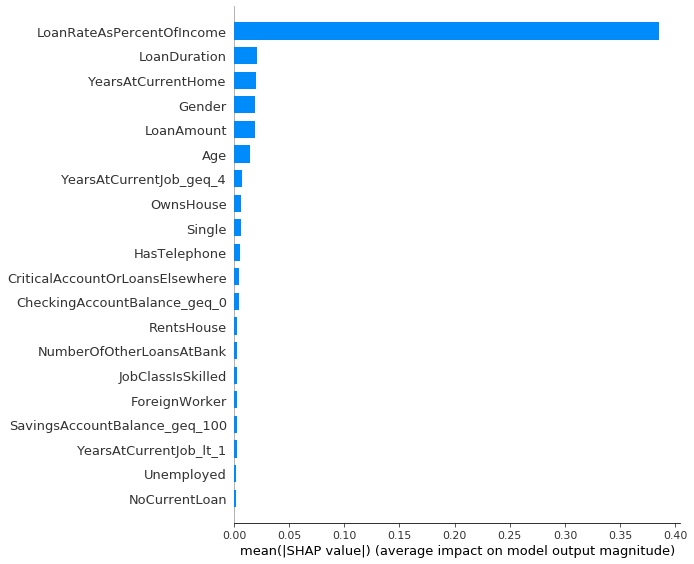

  0%|          | 0/250 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

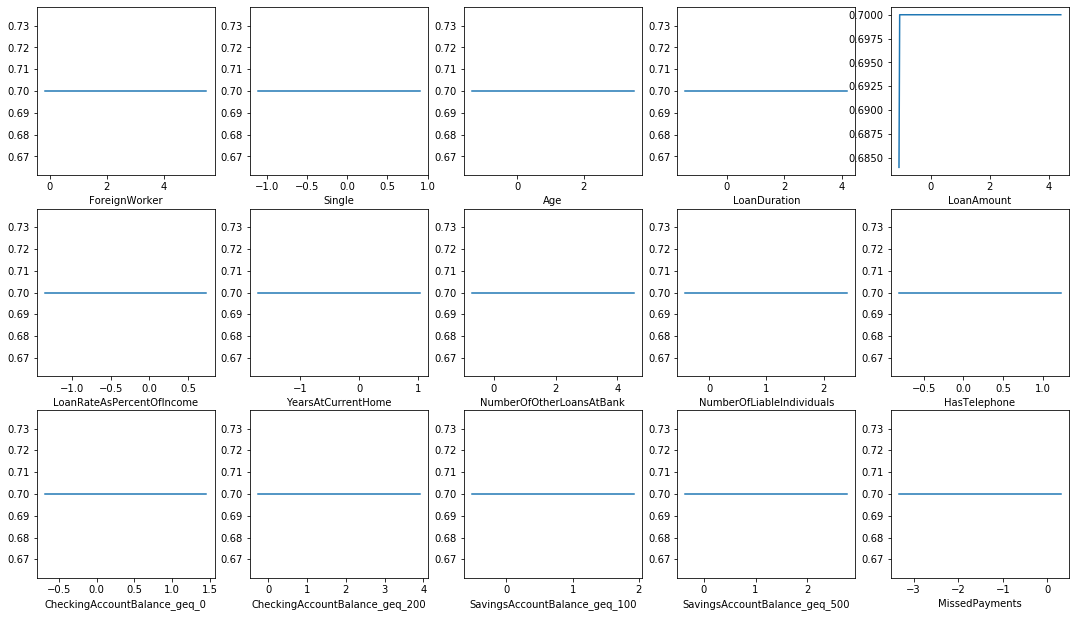

<Figure size 432x288 with 0 Axes>

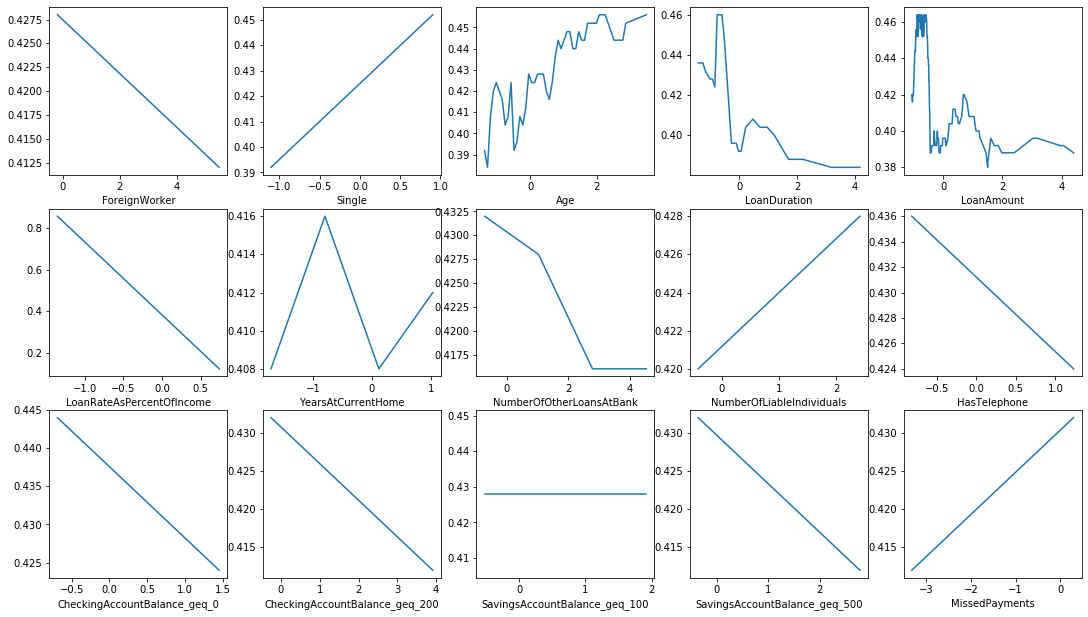

In [123]:
dataset = pd.read_csv("data/german_processed.csv")
dataset = dataset.drop(["PurposeOfLoan"], axis=1)
features = [c for c in dataset]
loan_rate_indc = features.index('LoanRateAsPercentOfIncome')
mean_lrpi = np.mean(dataset.values[:,loan_rate_indc])
loan_boolean = [1 if x[loan_rate_indc] > mean_lrpi else 0 for x in dataset.values]
dataset.drop(["LoanRateAsPercentOfIncome"], axis=1)
dataset['LoanRateAsPercentOfIncome'] = loan_boolean
categorical = ['Gender', 'ForeignWorker', 'Single', 'HasTelephone','CheckingAccountBalance_geq_0','CheckingAccountBalance_geq_200','SavingsAccountBalance_geq_100','SavingsAccountBalance_geq_500','MissedPayments','NoCurrentLoan','CriticalAccountOrLoansElsewhere','OtherLoansAtBank','OtherLoansAtStore','HasCoapplicant','HasGuarantor','OwnsHouse','RentsHouse','Unemployed','YearsAtCurrentJob_lt_1','YearsAtCurrentJob_geq_4','JobClassIsSkilled']

fools = FooLS(protected_class_name='Gender', protected_class_name_value=['Female'], unprotected_class_name='GoodCustomer', unprotected_class_name_value=[1], column_flag=ONE_EXISTING_COLUMN, correlated_column='LoanRateAsPercentOfIncome', categorical_feature_names=categorical, pd_dataset=dataset)
_,_ = fools.LIME_execute()
_,_ = fools.SHAP_execute()
fools.PDP_execute(fool_method=METHOD_LIME)
fools.PDP_execute(fool_method=METHOD_SHAP)

## Boston Housing Dataset
Apply our framework on a new dataset to examine its applicability. The results indicate so!

In [4]:
pd_bh = pd.read_csv("data/boston_housing.csv", index_col=0)

# we categorize the price into high and low
# and we do the same with the variable black
threshold = 50
y_col = 'medv'

# obtain both 50th percentile of both variables
y = pd_bh[y_col]
y_cutoff = np.percentile(y, threshold)
black_cutoff = np.percentile(pd_bh['black'], threshold)
pd_bh = pd_bh.drop([y_col], axis=1)

cols = [c for c in pd_bh]
# we cut both variables in 50th percentile
pd_bh['black'] = np.array([0 if val > black_cutoff else 1 for val in pd_bh['black']])
y = np.array([1 if val > y_cutoff else 0 for val in y])
pd_bh['medv'] = y

## LIME, SHAP, PDP Default Settings
We observe that:<br>
The fidility of the LIME approach is always higher than the fidility of the SHAP approach.<br>
The LIME approach makes the chosen feature in all iterations the most important feature with a value of 1.0.<br>
The SHAP approach makes the chosen feature also the most important feature (\~0.90). However, it does not achieve the high importance that LIME does.<br>
The sensitive feature does not have a high importance when using LIME, even in the 2nd and 3rd rank (\~0.05).<br>
The sensitive feature has a rather high importance when using SHAP on the 2nd and 3rd rank (\~0.30).<br>
The SHAP summary plot shows that all in all, the influence of the sensitive feature is successfully shifted to the chosen feature. However, the sensitive feature is still the 2nd most influencial feature (with a large difference to the 1st most influencial feature).<br>
The PDP plot could not be fooled by the adversarial models.<br>

---------------------
Iteration: 1 ; Used seed: 142076555
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007874015748031496), ('black', 0.007874015748031496), ('chas', 0.7874015748031497), ('crim', 0.015748031496062992), ('dis', 0.007874015748031496), ('indus', 0.023622047244094488), ('lstat', 0.031496062992125984), ('nox', 0.031496062992125984), ('ptratio', 0.023622047244094488), ('rad', 0.023622047244094488), ('rm', 0.007874015748031496), ('tax', 0.023622047244094488), ('zn', 0.007874015748031496)], 3: [('age', 0.07086614173228346), ('black', 0.05511811023622047), ('chas', 0.047244094488188976), ('crim', 0.07874015748031496), ('dis', 0.07086614173228346), ('indus', 0.06299212598425197), ('lstat', 0.12598425196850394), ('nox', 0.10236220472440945), ('ptratio', 0.11023622047244094), ('rad', 0.07874015748031496), ('rm', 0.047244094488188976), ('tax', 0.0708661417322

  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.015748031496062992), ('unrelated_column1', 0.9291338582677166), ('zn', 0.05511811023622047)], 2: [('age', 0.007874015748031496), ('black', 0.3858267716535433), ('chas', 0.007874015748031496), ('crim', 0.07874015748031496), ('dis', 0.023622047244094488), ('indus', 0.007874015748031496), ('lstat', 0.06299212598425197), ('nox', 0.12598425196850394), ('ptratio', 0.031496062992125984), ('rm', 0.007874015748031496), ('tax', 0.015748031496062992), ('unrelated_column1', 0.07086614173228346), ('zn', 0.1732283464566929)], 3: [('age', 0.10236220472440945), ('black', 0.14960629921259844), ('crim', 0.08661417322834646), ('dis', 0.07874015748031496), ('indus', 0.07874015748031496), ('lstat', 0.13385826771653545), ('nox', 0.14173228346456693), ('ptratio', 0.007874015748031496), ('rad', 0.015748031496062992), ('rm', 0.015748031496062992), ('tax', 0.031496062992125984), ('zn', 0.15748031496062992)]}
Fidelity: 0.88
------------------

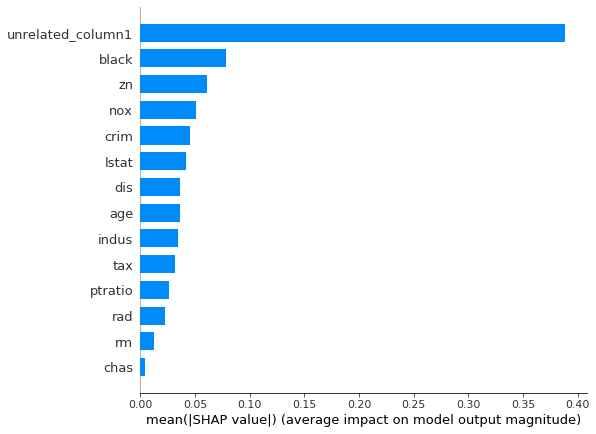

  0%|          | 0/127 [00:00<?, ?it/s]

---------------------
Iteration: 2 ; Used seed: 372944459
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007874015748031496), ('black', 0.007874015748031496), ('chas', 0.8582677165354331), ('crim', 0.015748031496062992), ('dis', 0.031496062992125984), ('lstat', 0.007874015748031496), ('nox', 0.007874015748031496), ('ptratio', 0.007874015748031496), ('rad', 0.023622047244094488), ('rm', 0.015748031496062992), ('tax', 0.015748031496062992)], 3: [('age', 0.11023622047244094), ('black', 0.11023622047244094), ('chas', 0.023622047244094488), ('crim', 0.06299212598425197), ('dis', 0.07874015748031496), ('indus', 0.06299212598425197), ('lstat', 0.06299212598425197), ('nox', 0.13385826771653545), ('ptratio', 0.06299212598425197), ('rad', 0.07874015748031496), ('rm', 0.07086614173228346), ('tax', 0.06299212598425197), ('zn', 0.07874015748031496)]}
Fidelity: 1.0


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.06299212598425197), ('unrelated_column1', 0.937007874015748)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.015748031496062992), ('black', 0.5275590551181102), ('crim', 0.06299212598425197), ('dis', 0.007874015748031496), ('indus', 0.03937007874015748), ('lstat', 0.031496062992125984), ('nox', 0.07086614173228346), ('ptratio', 0.05511811023622047), ('rad', 0.023622047244094488), ('tax', 0.06299212598425197), ('unrelated_column1', 0.06299212598425197), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.3228346456692913), ('age', 0.015748031496062992), ('black', 0.05511811023622047), ('crim', 0.11811023622047244), ('dis', 0.023622047244094488), ('indus', 0.047244094488188976), ('lstat', 0.015748031496062992), ('nox', 0.03937007874015748), ('ptratio', 0.07086614173228346), ('rad', 0.06299212598425197), ('tax', 0.15748031496062992), ('zn', 0.07086614173228346)]}
Fidelity: 0.94
---------------------


<Figure size 432x288 with 0 Axes>

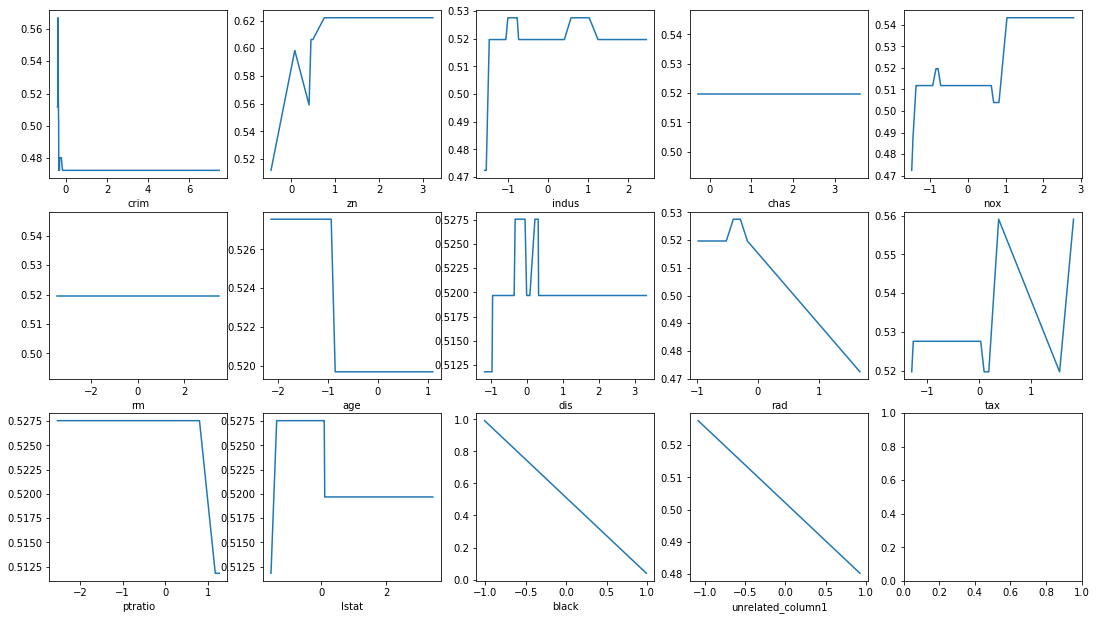

<Figure size 432x288 with 0 Axes>

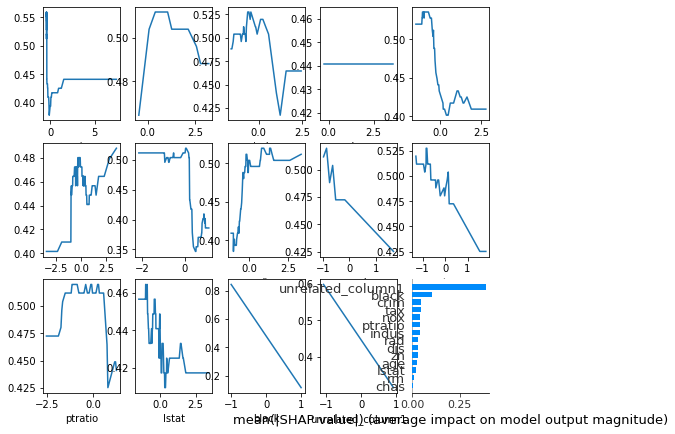

  0%|          | 0/127 [00:00<?, ?it/s]

---------------------
Iteration: 3 ; Used seed: 2521806709
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('black', 0.023622047244094488), ('chas', 0.8031496062992126), ('crim', 0.007874015748031496), ('dis', 0.015748031496062992), ('indus', 0.015748031496062992), ('lstat', 0.007874015748031496), ('ptratio', 0.007874015748031496), ('rad', 0.031496062992125984), ('rm', 0.03937007874015748), ('tax', 0.031496062992125984)], 3: [('age', 0.07086614173228346), ('black', 0.07086614173228346), ('chas', 0.047244094488188976), ('crim', 0.07086614173228346), ('dis', 0.11023622047244094), ('indus', 0.08661417322834646), ('lstat', 0.09448818897637795), ('nox', 0.10236220472440945), ('ptratio', 0.07086614173228346), ('rad', 0.07874015748031496), ('rm', 0.06299212598425197), ('tax', 0.07874015748031496), ('zn', 0.05511811023622047)]}
Fidelity: 0.98


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('age', 0.07086614173228346), ('black', 0.031496062992125984), ('nox', 0.015748031496062992), ('tax', 0.007874015748031496), ('unrelated_column1', 0.8740157480314961)], 2: [('age', 0.07086614173228346), ('black', 0.36220472440944884), ('crim', 0.023622047244094488), ('dis', 0.031496062992125984), ('indus', 0.06299212598425197), ('lstat', 0.007874015748031496), ('nox', 0.09448818897637795), ('ptratio', 0.07874015748031496), ('rad', 0.015748031496062992), ('tax', 0.08661417322834646), ('unrelated_column1', 0.09448818897637795), ('zn', 0.07086614173228346)], 3: [('Nothing shown', 0.007874015748031496), ('age', 0.16535433070866143), ('black', 0.05511811023622047), ('crim', 0.09448818897637795), ('dis', 0.07086614173228346), ('indus', 0.08661417322834646), ('lstat', 0.031496062992125984), ('nox', 0.2283464566929134), ('ptratio', 0.06299212598425197), ('rad', 0.023622047244094488), ('rm', 0.023622047244094488), ('tax', 0.047244094488

<Figure size 432x288 with 0 Axes>

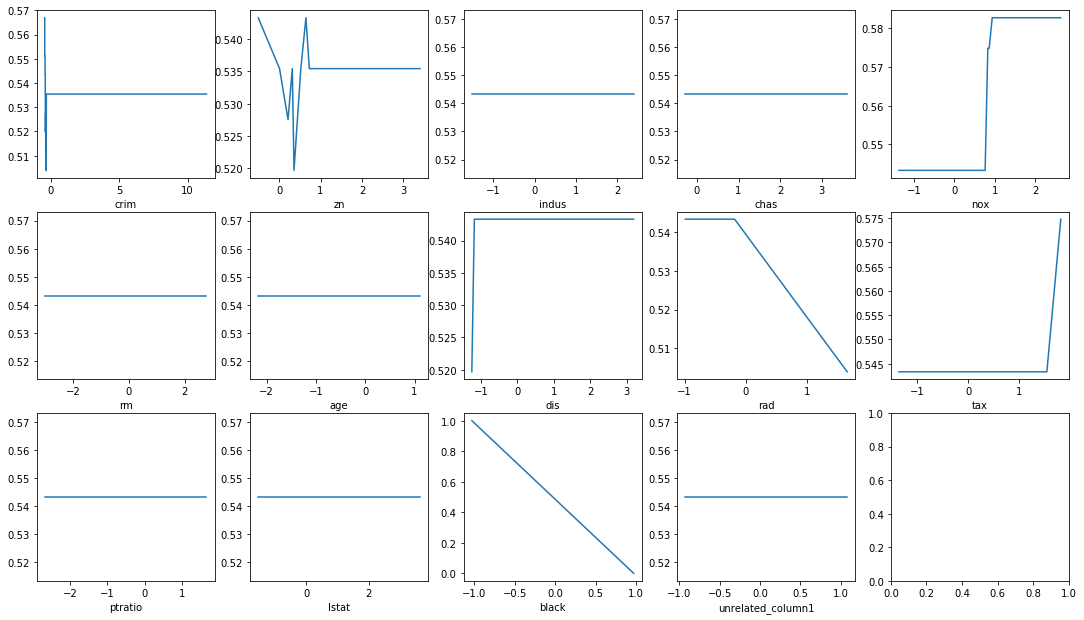

<Figure size 432x288 with 0 Axes>

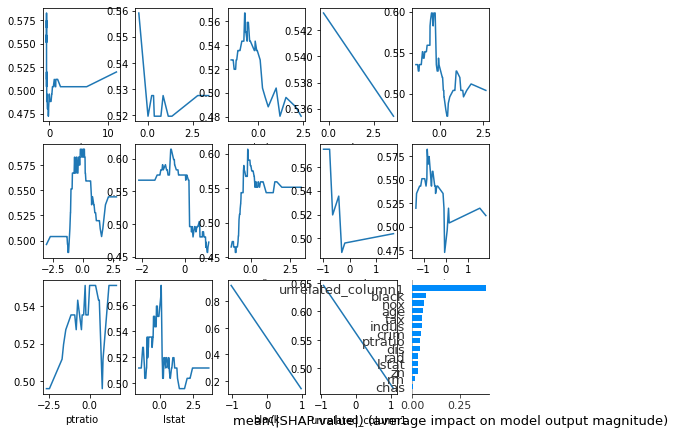

  0%|          | 0/127 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

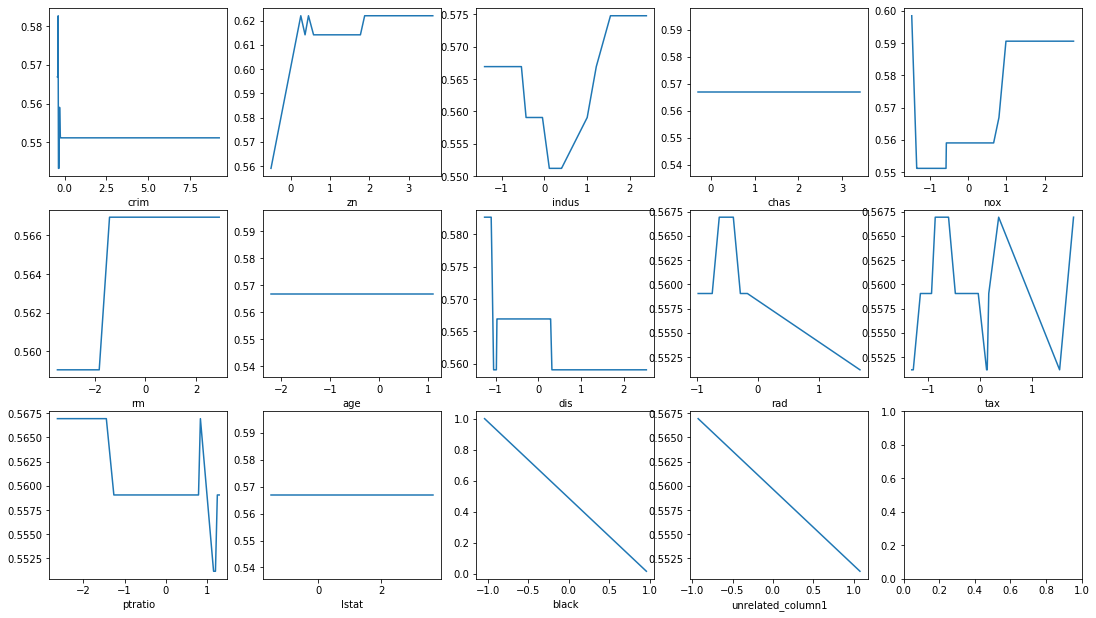

<Figure size 432x288 with 0 Axes>

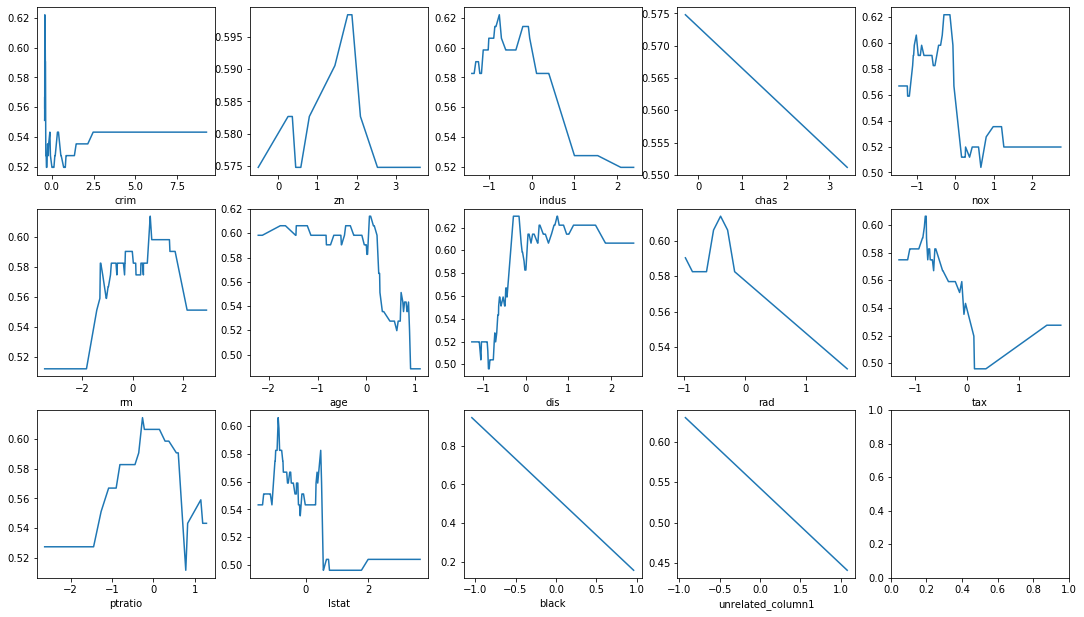

In [125]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _,_ = fools.LIME_execute()
    _,_ = fools.SHAP_execute()
    fools.PDP_execute(fool_method=METHOD_LIME)
    fools.PDP_execute(fool_method=METHOD_SHAP)

## Testing hyperparameters in LIME
In this case we are going to change the perturbation std and the perturbation multiplier in the perturbation algorithm and the number of random forest estimators in the local model.

### Changing std of the perturbation
We observe that:<br>
The fidility is not strongly affected (always > 0.98).<br>
The 1st most important feature is always the chosen feature nearly with a weight of 1.0.<br>
Interestingly, when using a standard derivation of 100 the importance of the sensitive feature on the 2nd and 3rd place is strongly increased (from next to nothing to \~0.40).

In [110]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for std in [0.1,0.3,0.5,1,10,100]:
        print("standard derivation of:", std)
        _,_ = fools.LIME_execute(perturbation_std=std)
        print("---------------------\n\n")

---------------------
Iteration: 1 ; Used seed: 3864463206
---------------------

standard derivation of: 0.1
LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.007874015748031496), ('chas', 0.7637795275590551), ('crim', 0.007874015748031496), ('dis', 0.007874015748031496), ('indus', 0.015748031496062992), ('lstat', 0.015748031496062992), ('nox', 0.015748031496062992), ('ptratio', 0.03937007874015748), ('rad', 0.015748031496062992), ('rm', 0.007874015748031496), ('tax', 0.031496062992125984), ('zn', 0.03937007874015748)], 3: [('age', 0.09448818897637795), ('black', 0.13385826771653545), ('chas', 0.07086614173228346), ('crim', 0.047244094488188976), ('dis', 0.06299212598425197), ('indus', 0.08661417322834646), ('lstat', 0.07086614173228346), ('nox', 0.08661417322834646), ('ptratio', 0.05511811023622047), ('rad', 0.08661417322834646), ('rm', 0.05511811023622047

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.05511811023622047), ('black', 0.07874015748031496), ('chas', 0.6614173228346457), ('crim', 0.015748031496062992), ('dis', 0.031496062992125984), ('indus', 0.007874015748031496), ('lstat', 0.031496062992125984), ('nox', 0.023622047244094488), ('ptratio', 0.023622047244094488), ('rm', 0.03937007874015748), ('tax', 0.015748031496062992), ('zn', 0.015748031496062992)], 3: [('age', 0.07874015748031496), ('black', 0.10236220472440945), ('chas', 0.05511811023622047), ('crim', 0.031496062992125984), ('dis', 0.11811023622047244), ('indus', 0.07086614173228346), ('lstat', 0.08661417322834646), ('nox', 0.07874015748031496), ('ptratio', 0.07874015748031496), ('rad', 0.08661417322834646), ('rm', 0.12598425196850394), ('tax', 0.007874015748031496), ('zn', 0.07874015748031496)]}
Fidelity: 0.98
---------------------


standard derivation of: 10
LIME Ranks a

### Changing perturbation multiplier
We observe that:<br>
The fidility is not strongly affected (always > 0.98).<br>
The 1st most important feature is always the chosen feature nearly with a weight of 1.0.<br>
Also, the sensitive feature does not have a high importance at all (even on the 2nd and 3rd rank)

In [111]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for pm in [1,10,30,60,100,1000]:
        print("permutation multiplier of :", pm)
        _,_ = fools.LIME_execute(perturbation_multiplier=pm)
        print("---------------------\n\n")

---------------------
Iteration: 1 ; Used seed: 178160412
---------------------

permutation multiplier of : 1
LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.047244094488188976), ('chas', 0.6535433070866141), ('crim', 0.007874015748031496), ('dis', 0.023622047244094488), ('indus', 0.015748031496062992), ('lstat', 0.031496062992125984), ('nox', 0.031496062992125984), ('ptratio', 0.03937007874015748), ('rad', 0.015748031496062992), ('rm', 0.023622047244094488), ('tax', 0.023622047244094488), ('zn', 0.05511811023622047)], 3: [('age', 0.09448818897637795), ('black', 0.07086614173228346), ('chas', 0.05511811023622047), ('crim', 0.06299212598425197), ('dis', 0.06299212598425197), ('indus', 0.12598425196850394), ('lstat', 0.09448818897637795), ('nox', 0.07874015748031496), ('ptratio', 0.08661417322834646), ('rad', 0.03937007874015748), ('rm', 0.05511811023622047

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.023622047244094488), ('black', 0.015748031496062992), ('chas', 0.7401574803149606), ('crim', 0.015748031496062992), ('dis', 0.031496062992125984), ('indus', 0.023622047244094488), ('lstat', 0.007874015748031496), ('nox', 0.031496062992125984), ('ptratio', 0.015748031496062992), ('rad', 0.03937007874015748), ('rm', 0.015748031496062992), ('tax', 0.031496062992125984), ('zn', 0.007874015748031496)], 3: [('age', 0.09448818897637795), ('black', 0.08661417322834646), ('chas', 0.07086614173228346), ('crim', 0.07086614173228346), ('dis', 0.07086614173228346), ('indus', 0.06299212598425197), ('lstat', 0.06299212598425197), ('nox', 0.05511811023622047), ('ptratio', 0.07086614173228346), ('rad', 0.07874015748031496), ('rm', 0.07874015748031496), ('tax', 0.08661417322834646), ('zn', 0.11023622047244094)]}
Fidelity: 0.99
---------------------


permutat

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.047244094488188976), ('black', 0.031496062992125984), ('chas', 0.7401574803149606), ('crim', 0.023622047244094488), ('dis', 0.007874015748031496), ('indus', 0.007874015748031496), ('lstat', 0.031496062992125984), ('nox', 0.023622047244094488), ('ptratio', 0.015748031496062992), ('rad', 0.015748031496062992), ('rm', 0.031496062992125984), ('tax', 0.007874015748031496), ('zn', 0.015748031496062992)], 3: [('age', 0.05511811023622047), ('black', 0.06299212598425197), ('chas', 0.07086614173228346), ('crim', 0.12598425196850394), ('dis', 0.031496062992125984), ('indus', 0.07874015748031496), ('lstat', 0.08661417322834646), ('nox', 0.07874015748031496), ('ptratio', 0.12598425196850394), ('rad', 0.07086614173228346), ('rm', 0.07086614173228346), ('tax', 0.06299212598425197), ('zn', 0.07874015748031496)]}
Fidelity: 1.0
---------------------




### Changing the number of random forest estimators
We observe that:<br>
The fidility is not strongly affected (always > 0.98).<br>
The 1st most important feature is always the chosen feature nearly with a weight of 1.0.<br>
Also, the sensitive feature does not have a high importance at all (even on the 2nd and 3rd rank)
Very similar to results when changing the permutation multiplier

In [112]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for rf in [10,50,100,200,300,1000]:
        print("random forrest estimator amount:", rf)
        fools.LIME_execute(rf_estimators=rf)
        print("---------------------\n\n")

---------------------
Iteration: 1 ; Used seed: 979099702
---------------------

random forrest estimator amount: 10
LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.023622047244094488), ('black', 0.023622047244094488), ('chas', 0.7716535433070866), ('crim', 0.023622047244094488), ('dis', 0.007874015748031496), ('lstat', 0.023622047244094488), ('nox', 0.023622047244094488), ('ptratio', 0.031496062992125984), ('rad', 0.047244094488188976), ('rm', 0.007874015748031496), ('zn', 0.015748031496062992)], 3: [('age', 0.11023622047244094), ('black', 0.07874015748031496), ('chas', 0.031496062992125984), ('crim', 0.09448818897637795), ('dis', 0.08661417322834646), ('indus', 0.09448818897637795), ('lstat', 0.11023622047244094), ('nox', 0.07874015748031496), ('ptratio', 0.047244094488188976), ('rad', 0.07086614173228346), ('rm', 0.07086614173228346), ('tax', 0.047244094488188976), ('zn', 0.07874015748

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007874015748031496), ('black', 0.023622047244094488), ('chas', 0.7952755905511811), ('crim', 0.015748031496062992), ('dis', 0.007874015748031496), ('indus', 0.03937007874015748), ('lstat', 0.015748031496062992), ('nox', 0.031496062992125984), ('ptratio', 0.031496062992125984), ('rad', 0.007874015748031496), ('tax', 0.007874015748031496), ('zn', 0.015748031496062992)], 3: [('age', 0.09448818897637795), ('black', 0.047244094488188976), ('chas', 0.031496062992125984), ('crim', 0.08661417322834646), ('dis', 0.05511811023622047), ('indus', 0.03937007874015748), ('lstat', 0.11023622047244094), ('nox', 0.07874015748031496), ('ptratio', 0.07874015748031496), ('rad', 0.09448818897637795), ('rm', 0.07874015748031496), ('tax', 0.09448818897637795), ('zn', 0.11023622047244094)]}
Fidelity: 1.0
---------------------


random forrest estimator amount: 300


Fidelity: 1.0
---------------------




## Testing hyperparameters in SHAP
In this case we are going to change the number of kmean clusters and the perturbation multiplier in the pertubation algorithm and the number of random forest estimators in the local model.

### Changing amount of k-means clusters
We observe that:<br>
With increasing amount of clusters the fidility drops strongly (from \~1.0 to \~0.83).<br>
The model successfully shifted the importance from the sensitive feature to the chosen feature on the 1st rank.<br>
With increasing amount of clusters the importance of the sensitive feature on the 2nd and 3rd rank is strongly increased (from next to nothing to up to \~0.92).<br>
The summary plot shows the steady increase of the sensitive feature influence with increasing number of clusters.<br>

---------------------
Iteration: 1 ; Used seed: 2441996702
---------------------

We are using 1 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Nothing shown', 0.23622047244094488), ('black', 0.047244094488188976), ('crim', 0.015748031496062992), ('dis', 0.03937007874015748), ('indus', 0.03937007874015748), ('lstat', 0.023622047244094488), ('nox', 0.007874015748031496), ('ptratio', 0.007874015748031496), ('rm', 0.007874015748031496), ('tax', 0.031496062992125984), ('unrelated_column1', 0.5354330708661418), ('zn', 0.007874015748031496)], 2: [('Nothing shown', 0.2440944881889764), ('black', 0.2992125984251969), ('crim', 0.047244094488188976), ('dis', 0.015748031496062992), ('indus', 0.047244094488188976), ('lstat', 0.015748031496062992), ('nox', 0.08661417322834646), ('ptratio', 0.06299212598425197), ('rad', 0.031496062992125984), ('tax', 0.08661417322834646), ('zn', 0.06299212598425197)], 3: [('Nothing shown', 0.25984251968503935), ('age', 0.031496062992125984), ('black', 0.07086614173228346), ('crim', 0.09448818897637795), ('dis', 0.08661417322834646), ('indus', 0.05

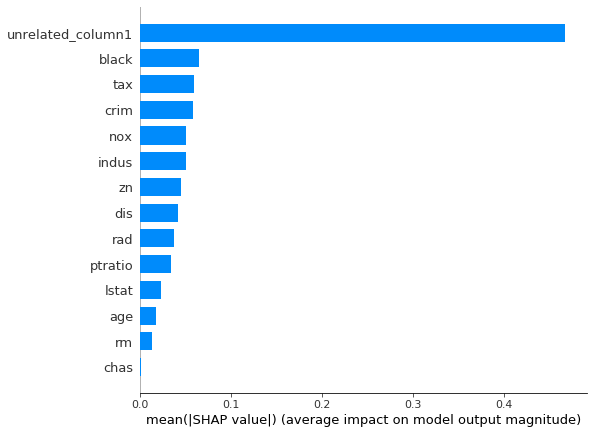

---------------------


We are using 5 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.16535433070866143), ('age', 0.06299212598425197), ('black', 0.4330708661417323), ('crim', 0.015748031496062992), ('dis', 0.03937007874015748), ('indus', 0.05511811023622047), ('lstat', 0.023622047244094488), ('nox', 0.07874015748031496), ('ptratio', 0.031496062992125984), ('rad', 0.007874015748031496), ('rm', 0.015748031496062992), ('tax', 0.05511811023622047), ('zn', 0.015748031496062992)], 3: [('Nothing shown', 0.4015748031496063), ('age', 0.07874015748031496), ('black', 0.031496062992125984), ('crim', 0.11023622047244094), ('dis', 0.05511811023622047), ('indus', 0.023622047244094488), ('nox', 0.07086614173228346), ('ptratio', 0.015748031496062992), ('rm', 0.09448818897637795), ('tax', 0.09448818897637795), ('zn', 0.023622047244094488)]}
Fidelity: 0.89
---------------------


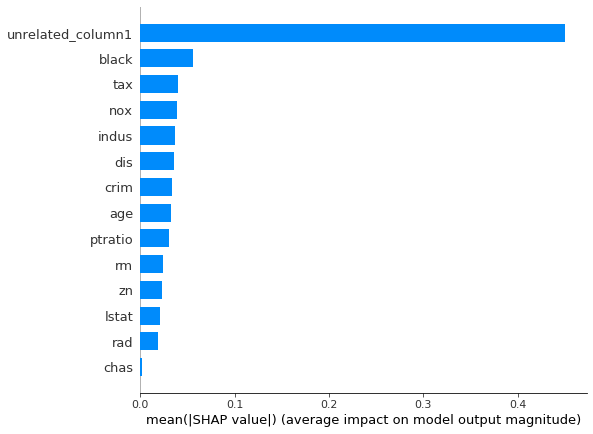

---------------------


We are using 10 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.047244094488188976), ('black', 0.6141732283464567), ('crim', 0.03937007874015748), ('dis', 0.023622047244094488), ('indus', 0.03937007874015748), ('lstat', 0.023622047244094488), ('nox', 0.031496062992125984), ('ptratio', 0.015748031496062992), ('rad', 0.015748031496062992), ('rm', 0.015748031496062992), ('tax', 0.13385826771653545)], 3: [('Nothing shown', 0.07874015748031496), ('age', 0.015748031496062992), ('black', 0.11811023622047244), ('crim', 0.14173228346456693), ('dis', 0.031496062992125984), ('indus', 0.09448818897637795), ('lstat', 0.031496062992125984), ('nox', 0.10236220472440945), ('ptratio', 0.047244094488188976), ('rad', 0.07086614173228346), ('rm', 0.007874015748031496), ('tax', 0.15748031496062992), ('zn', 0.10236220472440945)]}
Fidelity: 0.89
---------------------


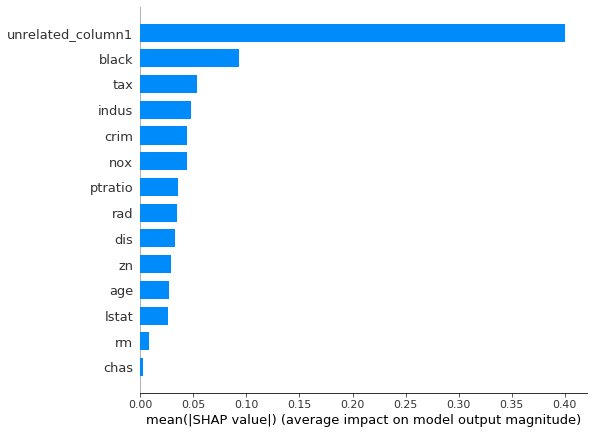

---------------------


We are using 50 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.7480314960629921), ('crim', 0.047244094488188976), ('lstat', 0.031496062992125984), ('nox', 0.03937007874015748), ('ptratio', 0.031496062992125984), ('rad', 0.031496062992125984), ('rm', 0.007874015748031496), ('tax', 0.023622047244094488), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.10236220472440945), ('age', 0.03937007874015748), ('black', 0.11023622047244094), ('crim', 0.2125984251968504), ('dis', 0.031496062992125984), ('indus', 0.11811023622047244), ('lstat', 0.015748031496062992), ('nox', 0.07086614173228346), ('ptratio', 0.03937007874015748), ('rad', 0.07086614173228346), ('rm', 0.031496062992125984), ('tax', 0.13385826771653545), ('zn', 0.023622047244094488)]}
Fidelity: 0.85
---------------------


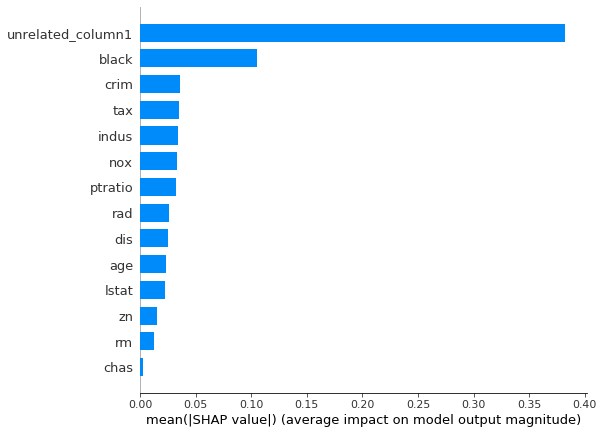

---------------------


We are using 100 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.023622047244094488), ('black', 0.8110236220472441), ('crim', 0.007874015748031496), ('dis', 0.007874015748031496), ('indus', 0.023622047244094488), ('lstat', 0.015748031496062992), ('nox', 0.031496062992125984), ('ptratio', 0.007874015748031496), ('rad', 0.007874015748031496), ('rm', 0.023622047244094488), ('tax', 0.03937007874015748)], 3: [('Nothing shown', 0.08661417322834646), ('age', 0.05511811023622047), ('black', 0.12598425196850394), ('crim', 0.14173228346456693), ('dis', 0.05511811023622047), ('indus', 0.11023622047244094), ('lstat', 0.023622047244094488), ('nox', 0.031496062992125984), ('ptratio', 0.06299212598425197), ('rad', 0.07086614173228346), ('rm', 0.015748031496062992), ('tax', 0.13385826771653545), ('zn', 0.08661417322834646)]}
Fidelity: 0.87
---------------------


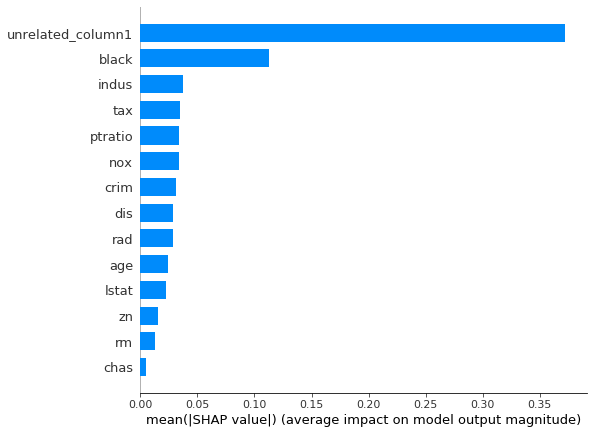

---------------------


We are using 200 K-mean clusters


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007874015748031496), ('black', 0.952755905511811), ('chas', 0.007874015748031496), ('dis', 0.007874015748031496), ('lstat', 0.007874015748031496), ('rm', 0.015748031496062992)], 3: [('Nothing shown', 0.15748031496062992), ('age', 0.047244094488188976), ('black', 0.03937007874015748), ('crim', 0.07874015748031496), ('dis', 0.06299212598425197), ('indus', 0.10236220472440945), ('lstat', 0.03937007874015748), ('nox', 0.05511811023622047), ('ptratio', 0.12598425196850394), ('rad', 0.05511811023622047), ('rm', 0.047244094488188976), ('tax', 0.10236220472440945), ('zn', 0.08661417322834646)]}
Fidelity: 0.83
---------------------


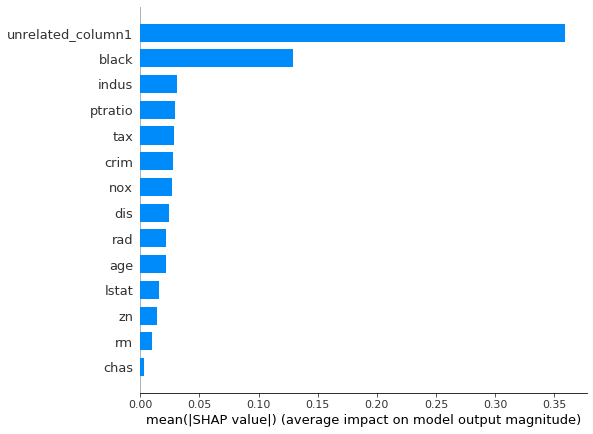

---------------------


---------------------
Iteration: 2 ; Used seed: 589918190
---------------------

We are using 1 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Nothing shown', 0.23622047244094488), ('black', 0.05511811023622047), ('crim', 0.03937007874015748), ('dis', 0.007874015748031496), ('indus', 0.023622047244094488), ('lstat', 0.015748031496062992), ('nox', 0.047244094488188976), ('rad', 0.05511811023622047), ('rm', 0.007874015748031496), ('tax', 0.023622047244094488), ('unrelated_column1', 0.48031496062992124), ('zn', 0.007874015748031496)], 2: [('Nothing shown', 0.23622047244094488), ('black', 0.2755905511811024), ('crim', 0.047244094488188976), ('dis', 0.031496062992125984), ('indus', 0.07086614173228346), ('lstat', 0.023622047244094488), ('nox', 0.03937007874015748), ('ptratio', 0.023622047244094488), ('rad', 0.12598425196850394), ('rm', 0.007874015748031496), ('tax', 0.06299212598425197), ('zn', 0.05511811023622047)], 3: [('Nothing shown', 0.25984251968503935), ('age', 0.031496062992125984), ('black', 0.09448818897637795), ('crim', 0.07874015748031496), ('dis', 0.11023622

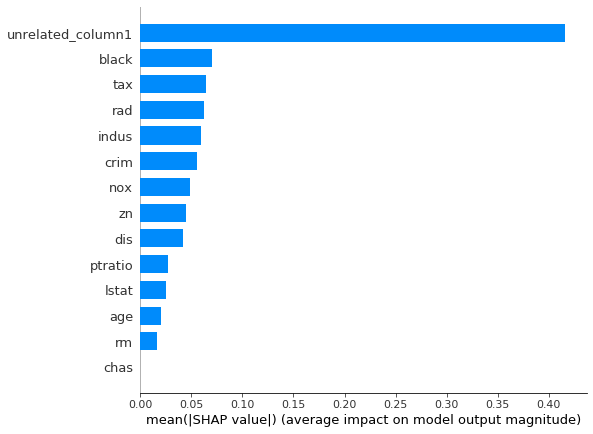

---------------------


We are using 5 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.12598425196850394), ('age', 0.023622047244094488), ('black', 0.3937007874015748), ('crim', 0.08661417322834646), ('dis', 0.07086614173228346), ('indus', 0.031496062992125984), ('lstat', 0.015748031496062992), ('nox', 0.03937007874015748), ('ptratio', 0.09448818897637795), ('rad', 0.007874015748031496), ('rm', 0.03937007874015748), ('tax', 0.07086614173228346)], 3: [('Nothing shown', 0.2677165354330709), ('age', 0.07086614173228346), ('black', 0.023622047244094488), ('crim', 0.16535433070866143), ('dis', 0.03937007874015748), ('indus', 0.03937007874015748), ('lstat', 0.047244094488188976), ('nox', 0.07086614173228346), ('ptratio', 0.11023622047244094), ('rad', 0.023622047244094488), ('rm', 0.007874015748031496), ('tax', 0.08661417322834646), ('zn', 0.047244094488188976)]}
Fidelity: 0.91
---------------------


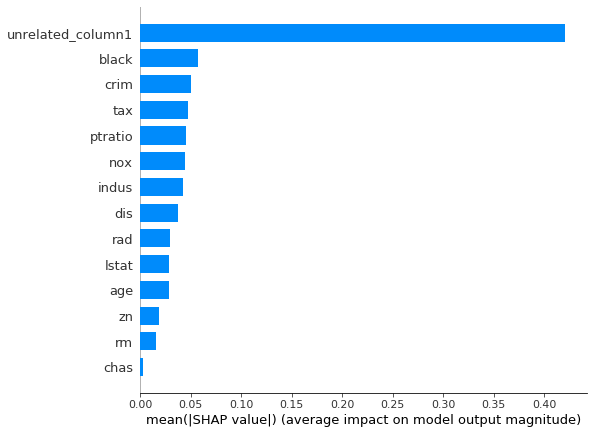

---------------------


We are using 10 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.08661417322834646), ('black', 0.47244094488188976), ('crim', 0.03937007874015748), ('dis', 0.031496062992125984), ('indus', 0.05511811023622047), ('lstat', 0.05511811023622047), ('nox', 0.023622047244094488), ('ptratio', 0.015748031496062992), ('rm', 0.09448818897637795), ('tax', 0.08661417322834646), ('zn', 0.03937007874015748)], 3: [('Nothing shown', 0.023622047244094488), ('age', 0.09448818897637795), ('black', 0.11023622047244094), ('crim', 0.09448818897637795), ('dis', 0.03937007874015748), ('indus', 0.07874015748031496), ('lstat', 0.10236220472440945), ('nox', 0.09448818897637795), ('ptratio', 0.06299212598425197), ('rad', 0.023622047244094488), ('rm', 0.1732283464566929), ('tax', 0.05511811023622047), ('zn', 0.047244094488188976)]}
Fidelity: 0.88
---------------------


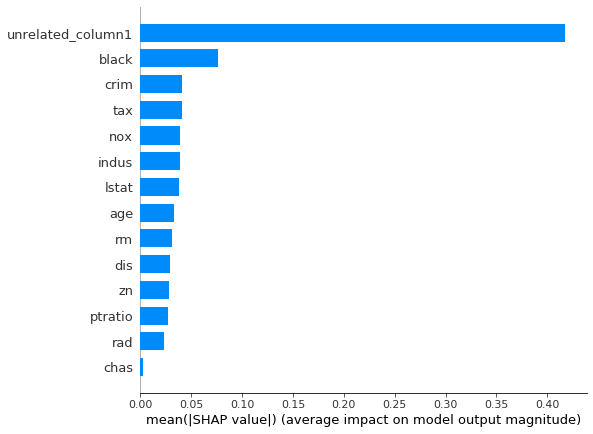

---------------------


We are using 50 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('black', 0.7559055118110236), ('chas', 0.015748031496062992), ('crim', 0.023622047244094488), ('indus', 0.015748031496062992), ('lstat', 0.015748031496062992), ('nox', 0.007874015748031496), ('ptratio', 0.031496062992125984), ('rad', 0.023622047244094488), ('tax', 0.09448818897637795)], 3: [('Nothing shown', 0.10236220472440945), ('age', 0.07086614173228346), ('black', 0.12598425196850394), ('chas', 0.007874015748031496), ('crim', 0.11023622047244094), ('dis', 0.08661417322834646), ('indus', 0.16535433070866143), ('lstat', 0.05511811023622047), ('nox', 0.06299212598425197), ('ptratio', 0.031496062992125984), ('rad', 0.047244094488188976), ('rm', 0.015748031496062992), ('tax', 0.09448818897637795), ('zn', 0.023622047244094488)]}
Fidelity: 0.87
---------------------


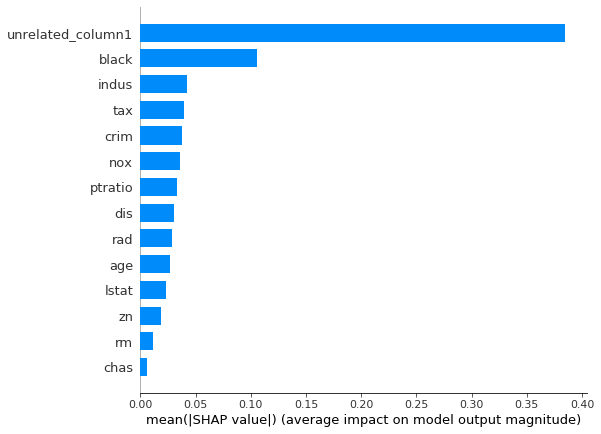

---------------------


We are using 100 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.7952755905511811), ('chas', 0.007874015748031496), ('dis', 0.007874015748031496), ('indus', 0.015748031496062992), ('lstat', 0.031496062992125984), ('nox', 0.023622047244094488), ('ptratio', 0.047244094488188976), ('rad', 0.007874015748031496), ('tax', 0.031496062992125984)], 3: [('Nothing shown', 0.07086614173228346), ('age', 0.047244094488188976), ('black', 0.14173228346456693), ('crim', 0.06299212598425197), ('dis', 0.06299212598425197), ('indus', 0.11023622047244094), ('lstat', 0.007874015748031496), ('nox', 0.06299212598425197), ('ptratio', 0.1732283464566929), ('rad', 0.07086614173228346), ('rm', 0.023622047244094488), ('tax', 0.11023622047244094), ('zn', 0.05511811023622047)]}
Fidelity: 0.87
---------------------


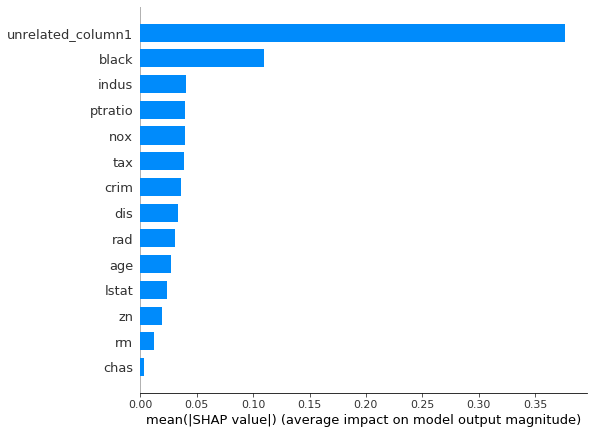

---------------------


We are using 200 K-mean clusters


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.9212598425196851), ('chas', 0.007874015748031496), ('lstat', 0.031496062992125984), ('rm', 0.007874015748031496)], 3: [('Nothing shown', 0.09448818897637795), ('age', 0.03937007874015748), ('black', 0.07874015748031496), ('crim', 0.10236220472440945), ('dis', 0.07874015748031496), ('indus', 0.11811023622047244), ('lstat', 0.03937007874015748), ('nox', 0.05511811023622047), ('ptratio', 0.07874015748031496), ('rad', 0.10236220472440945), ('rm', 0.007874015748031496), ('tax', 0.12598425196850394), ('zn', 0.07874015748031496)]}
Fidelity: 0.85
---------------------


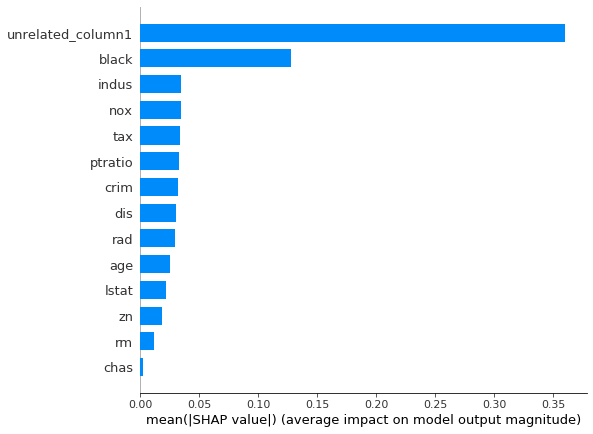

---------------------


---------------------
Iteration: 3 ; Used seed: 797138181
---------------------

We are using 1 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Nothing shown', 0.2677165354330709), ('age', 0.007874015748031496), ('black', 0.047244094488188976), ('crim', 0.023622047244094488), ('dis', 0.031496062992125984), ('indus', 0.015748031496062992), ('lstat', 0.007874015748031496), ('nox', 0.015748031496062992), ('ptratio', 0.023622047244094488), ('rad', 0.031496062992125984), ('tax', 0.05511811023622047), ('unrelated_column1', 0.4645669291338583), ('zn', 0.007874015748031496)], 2: [('Nothing shown', 0.2755905511811024), ('age', 0.007874015748031496), ('black', 0.2755905511811024), ('crim', 0.03937007874015748), ('dis', 0.03937007874015748), ('indus', 0.07874015748031496), ('lstat', 0.015748031496062992), ('nox', 0.06299212598425197), ('ptratio', 0.023622047244094488), ('rad', 0.06299212598425197), ('rm', 0.007874015748031496), ('tax', 0.06299212598425197), ('zn', 0.047244094488188976)], 3: [('Nothing shown', 0.28346456692913385), ('age', 0.031496062992125984), ('black', 0.0393

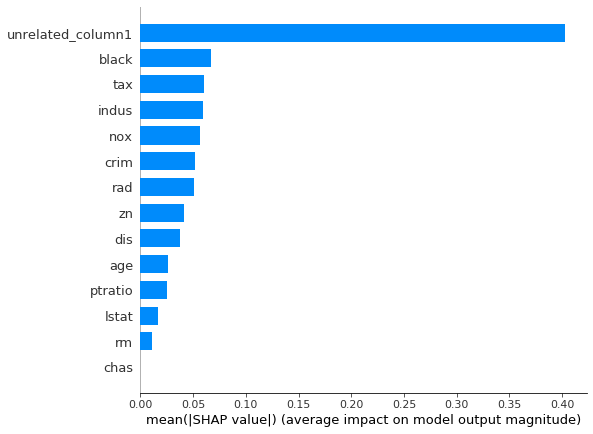

---------------------


We are using 5 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.15748031496062992), ('age', 0.023622047244094488), ('black', 0.4251968503937008), ('chas', 0.007874015748031496), ('crim', 0.031496062992125984), ('indus', 0.031496062992125984), ('lstat', 0.03937007874015748), ('nox', 0.08661417322834646), ('ptratio', 0.05511811023622047), ('rad', 0.015748031496062992), ('rm', 0.03937007874015748), ('tax', 0.07874015748031496), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.5039370078740157), ('age', 0.047244094488188976), ('black', 0.03937007874015748), ('crim', 0.09448818897637795), ('dis', 0.023622047244094488), ('indus', 0.023622047244094488), ('lstat', 0.03937007874015748), ('nox', 0.07874015748031496), ('ptratio', 0.06299212598425197), ('rad', 0.031496062992125984), ('rm', 0.023622047244094488), ('tax', 0.015748031496062992), ('zn', 0.015748031496062992)]}
Fidelity: 0.92
---------------------


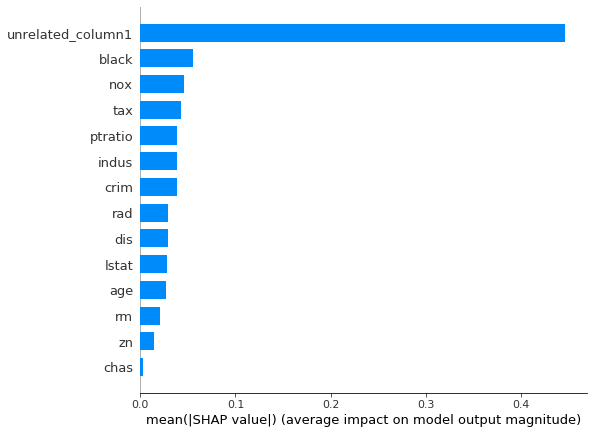

---------------------


We are using 10 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.06299212598425197), ('age', 0.007874015748031496), ('black', 0.5196850393700787), ('crim', 0.03937007874015748), ('dis', 0.015748031496062992), ('indus', 0.023622047244094488), ('lstat', 0.031496062992125984), ('nox', 0.11023622047244094), ('ptratio', 0.047244094488188976), ('rad', 0.023622047244094488), ('rm', 0.023622047244094488), ('tax', 0.06299212598425197), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.29133858267716534), ('age', 0.007874015748031496), ('black', 0.05511811023622047), ('crim', 0.16535433070866143), ('dis', 0.015748031496062992), ('indus', 0.11811023622047244), ('lstat', 0.007874015748031496), ('nox', 0.13385826771653545), ('ptratio', 0.03937007874015748), ('rad', 0.015748031496062992), ('rm', 0.015748031496062992), ('tax', 0.08661417322834646), ('zn', 0.047244094488188976)]}
Fidelity: 0.87
---------------------


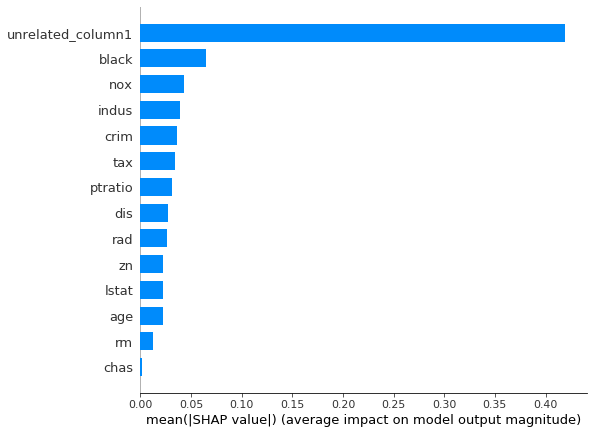

---------------------


We are using 50 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('black', 0.7559055118110236), ('chas', 0.007874015748031496), ('crim', 0.023622047244094488), ('dis', 0.007874015748031496), ('indus', 0.007874015748031496), ('lstat', 0.007874015748031496), ('nox', 0.023622047244094488), ('ptratio', 0.06299212598425197), ('rad', 0.007874015748031496), ('rm', 0.031496062992125984), ('tax', 0.047244094488188976)], 3: [('Nothing shown', 0.18110236220472442), ('age', 0.031496062992125984), ('black', 0.11811023622047244), ('crim', 0.14173228346456693), ('dis', 0.03937007874015748), ('indus', 0.07086614173228346), ('lstat', 0.03937007874015748), ('nox', 0.06299212598425197), ('ptratio', 0.11023622047244094), ('rad', 0.05511811023622047), ('rm', 0.023622047244094488), ('tax', 0.07874015748031496), ('zn', 0.047244094488188976)]}
Fidelity: 0.87
---------------------


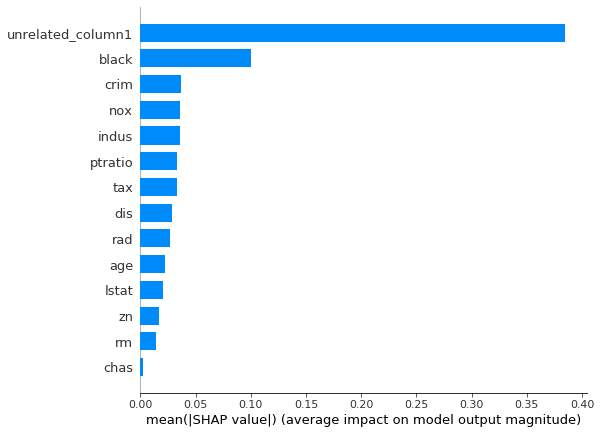

---------------------


We are using 100 K-mean clusters


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('black', 0.889763779527559), ('chas', 0.007874015748031496), ('crim', 0.015748031496062992), ('indus', 0.007874015748031496), ('lstat', 0.007874015748031496), ('nox', 0.007874015748031496), ('ptratio', 0.03937007874015748), ('rm', 0.015748031496062992), ('tax', 0.007874015748031496)], 3: [('Nothing shown', 0.1732283464566929), ('age', 0.05511811023622047), ('black', 0.07874015748031496), ('crim', 0.07874015748031496), ('dis', 0.09448818897637795), ('indus', 0.07874015748031496), ('lstat', 0.03937007874015748), ('nox', 0.03937007874015748), ('ptratio', 0.15748031496062992), ('rad', 0.05511811023622047), ('rm', 0.023622047244094488), ('tax', 0.07874015748031496), ('zn', 0.047244094488188976)]}
Fidelity: 0.87
---------------------


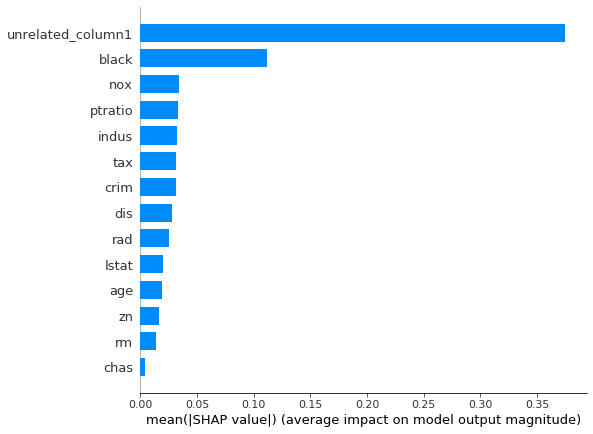

---------------------


We are using 200 K-mean clusters


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('black', 0.952755905511811), ('lstat', 0.015748031496062992), ('nox', 0.007874015748031496), ('ptratio', 0.007874015748031496), ('rm', 0.015748031496062992)], 3: [('Nothing shown', 0.11811023622047244), ('age', 0.08661417322834646), ('black', 0.047244094488188976), ('chas', 0.007874015748031496), ('crim', 0.05511811023622047), ('dis', 0.13385826771653545), ('indus', 0.07874015748031496), ('lstat', 0.031496062992125984), ('nox', 0.11023622047244094), ('ptratio', 0.09448818897637795), ('rad', 0.07086614173228346), ('rm', 0.031496062992125984), ('tax', 0.10236220472440945), ('zn', 0.031496062992125984)]}
Fidelity: 0.87
---------------------


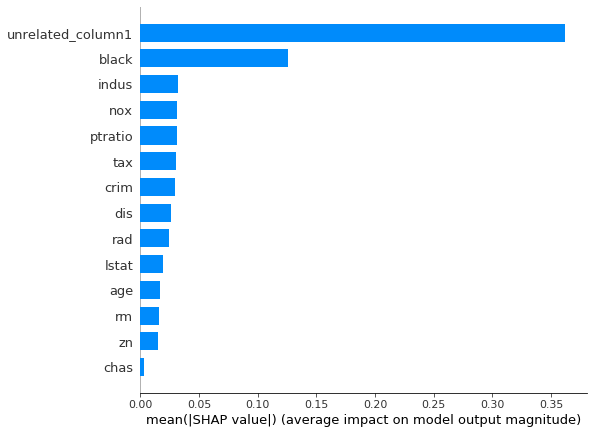

---------------------




In [113]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for n_kmeans in [1,5,10,50,100,200]:
        print ("We are using", n_kmeans, "K-mean clusters")
        fools.SHAP_execute(cluster=n_kmeans)
        print("---------------------\n\n")

### Changing the perturbation multiplier
We observe that:<br>
With a higher perturbation multiplier the fidility rises (from \~0.65 to \~0.9).<br>
The model successfully shifted the importance from the sensitive feature to the chosen feature on the 1st rank.<br>
With a higher perturbation multiplier the importance of the sensitive feature on the 2nd and 3rd rank is increased (from next to nothing to up to \~0.50).<br>
The summary plot shows the steady increase of the sensitive feature influence with a higher perturbation multiplier.<br>

---------------------
Iteration: 1 ; Used seed: 1361042237
---------------------

We are using a perturbation multiplier of 1


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.7007874015748031), ('age', 0.023622047244094488), ('black', 0.16535433070866143), ('crim', 0.015748031496062992), ('lstat', 0.023622047244094488), ('nox', 0.03937007874015748), ('ptratio', 0.007874015748031496), ('rad', 0.015748031496062992), ('tax', 0.007874015748031496)], 3: [('Nothing shown', 0.8267716535433071), ('age', 0.023622047244094488), ('crim', 0.047244094488188976), ('dis', 0.023622047244094488), ('indus', 0.007874015748031496), ('lstat', 0.007874015748031496), ('nox', 0.05511811023622047), ('tax', 0.007874015748031496)]}
Fidelity: 0.63
---------------------


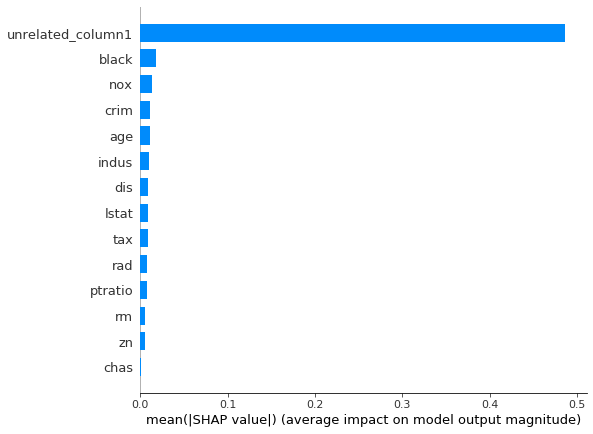

---------------------


We are using a perturbation multiplier of 5


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.2204724409448819), ('age', 0.031496062992125984), ('black', 0.41732283464566927), ('crim', 0.03937007874015748), ('dis', 0.023622047244094488), ('indus', 0.023622047244094488), ('lstat', 0.03937007874015748), ('nox', 0.08661417322834646), ('ptratio', 0.015748031496062992), ('rad', 0.023622047244094488), ('rm', 0.015748031496062992), ('tax', 0.03937007874015748), ('zn', 0.023622047244094488)], 3: [('Nothing shown', 0.5275590551181102), ('age', 0.06299212598425197), ('black', 0.031496062992125984), ('crim', 0.03937007874015748), ('dis', 0.031496062992125984), ('indus', 0.023622047244094488), ('lstat', 0.023622047244094488), ('nox', 0.10236220472440945), ('ptratio', 0.015748031496062992), ('rad', 0.03937007874015748), ('rm', 0.023622047244094488), ('tax', 0.047244094488188976), ('zn', 0.031496062992125984)]}
Fidelity: 0.76
---------------------


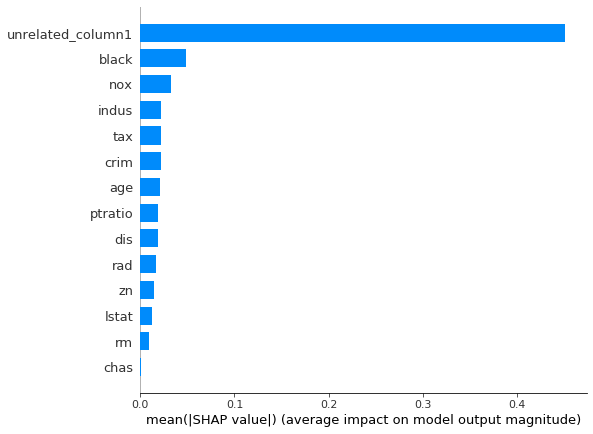

---------------------


We are using a perturbation multiplier of 10


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.1968503937007874), ('age', 0.06299212598425197), ('black', 0.3543307086614173), ('crim', 0.023622047244094488), ('dis', 0.03937007874015748), ('lstat', 0.03937007874015748), ('nox', 0.09448818897637795), ('ptratio', 0.05511811023622047), ('rad', 0.031496062992125984), ('rm', 0.031496062992125984), ('tax', 0.047244094488188976), ('zn', 0.023622047244094488)], 3: [('Nothing shown', 0.4251968503937008), ('age', 0.06299212598425197), ('black', 0.031496062992125984), ('crim', 0.07086614173228346), ('dis', 0.03937007874015748), ('indus', 0.06299212598425197), ('lstat', 0.015748031496062992), ('nox', 0.11811023622047244), ('ptratio', 0.047244094488188976), ('rad', 0.023622047244094488), ('rm', 0.007874015748031496), ('tax', 0.07874015748031496), ('zn', 0.015748031496062992)]}
Fidelity: 0.83
---------------------


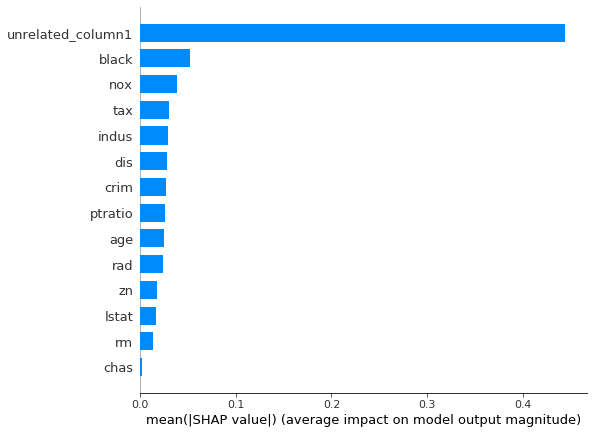

---------------------


We are using a perturbation multiplier of 50


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.09448818897637795), ('age', 0.031496062992125984), ('black', 0.44881889763779526), ('crim', 0.023622047244094488), ('dis', 0.015748031496062992), ('indus', 0.05511811023622047), ('lstat', 0.031496062992125984), ('nox', 0.10236220472440945), ('ptratio', 0.06299212598425197), ('rad', 0.023622047244094488), ('rm', 0.023622047244094488), ('tax', 0.03937007874015748), ('zn', 0.047244094488188976)], 3: [('Nothing shown', 0.4330708661417323), ('age', 0.06299212598425197), ('black', 0.07086614173228346), ('crim', 0.047244094488188976), ('dis', 0.023622047244094488), ('indus', 0.03937007874015748), ('lstat', 0.023622047244094488), ('nox', 0.07874015748031496), ('ptratio', 0.03937007874015748), ('rad', 0.023622047244094488), ('rm', 0.031496062992125984), ('tax', 0.10236220472440945), ('zn', 0.023622047244094488)]}
Fidelity: 0.83
---------------------


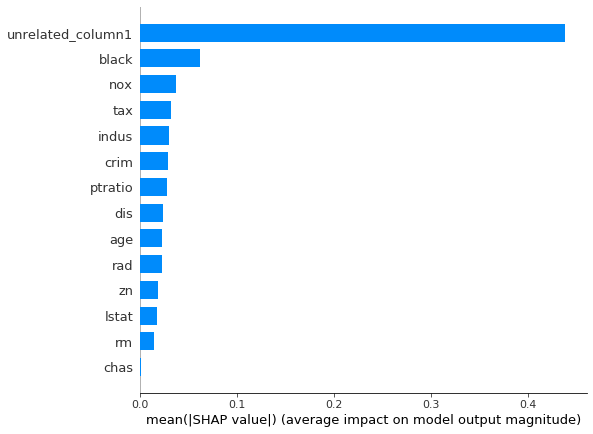

---------------------


We are using a perturbation multiplier of 100


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.12598425196850394), ('age', 0.09448818897637795), ('black', 0.4409448818897638), ('crim', 0.031496062992125984), ('dis', 0.031496062992125984), ('indus', 0.07086614173228346), ('lstat', 0.015748031496062992), ('nox', 0.05511811023622047), ('ptratio', 0.023622047244094488), ('rad', 0.007874015748031496), ('rm', 0.015748031496062992), ('tax', 0.047244094488188976), ('zn', 0.03937007874015748)], 3: [('Nothing shown', 0.3858267716535433), ('age', 0.047244094488188976), ('black', 0.05511811023622047), ('crim', 0.06299212598425197), ('dis', 0.05511811023622047), ('indus', 0.06299212598425197), ('lstat', 0.031496062992125984), ('nox', 0.12598425196850394), ('ptratio', 0.06299212598425197), ('rad', 0.031496062992125984), ('rm', 0.007874015748031496), ('tax', 0.031496062992125984), ('zn', 0.03937007874015748)]}
Fidelity: 0.84
---------------------


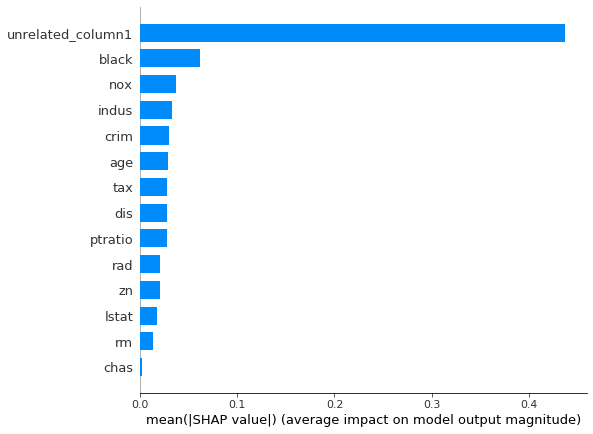

---------------------


We are using a perturbation multiplier of 200


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.10236220472440945), ('age', 0.023622047244094488), ('black', 0.4094488188976378), ('crim', 0.06299212598425197), ('dis', 0.03937007874015748), ('indus', 0.08661417322834646), ('lstat', 0.031496062992125984), ('nox', 0.06299212598425197), ('ptratio', 0.03937007874015748), ('rad', 0.007874015748031496), ('rm', 0.023622047244094488), ('tax', 0.07086614173228346), ('zn', 0.03937007874015748)], 3: [('Nothing shown', 0.3700787401574803), ('age', 0.06299212598425197), ('black', 0.07086614173228346), ('crim', 0.05511811023622047), ('dis', 0.05511811023622047), ('indus', 0.05511811023622047), ('lstat', 0.03937007874015748), ('nox', 0.14960629921259844), ('ptratio', 0.05511811023622047), ('rad', 0.015748031496062992), ('rm', 0.023622047244094488), ('tax', 0.031496062992125984), ('zn', 0.015748031496062992)]}
Fidelity: 0.85
---------------------


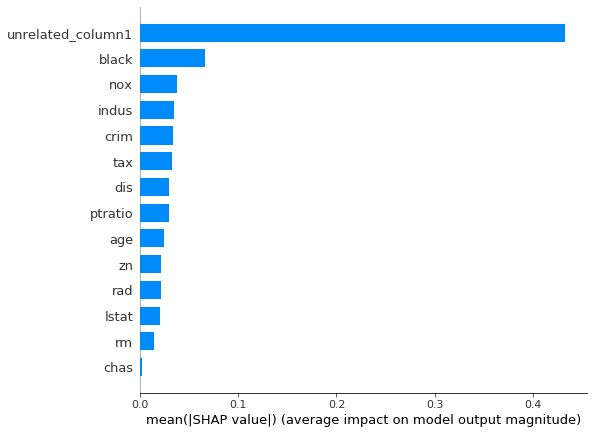

---------------------


---------------------
Iteration: 2 ; Used seed: 2989687966
---------------------

We are using a perturbation multiplier of 1


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.31496062992125984), ('age', 0.023622047244094488), ('black', 0.3858267716535433), ('crim', 0.031496062992125984), ('dis', 0.031496062992125984), ('indus', 0.031496062992125984), ('lstat', 0.023622047244094488), ('nox', 0.05511811023622047), ('ptratio', 0.015748031496062992), ('rm', 0.007874015748031496), ('tax', 0.07086614173228346), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.5433070866141733), ('age', 0.023622047244094488), ('black', 0.015748031496062992), ('crim', 0.05511811023622047), ('dis', 0.03937007874015748), ('indus', 0.06299212598425197), ('lstat', 0.023622047244094488), ('nox', 0.07086614173228346), ('ptratio', 0.031496062992125984), ('rad', 0.007874015748031496), ('rm', 0.031496062992125984), ('tax', 0.05511811023622047), ('zn', 0.03937007874015748)]}
Fidelity: 0.72
---------------------


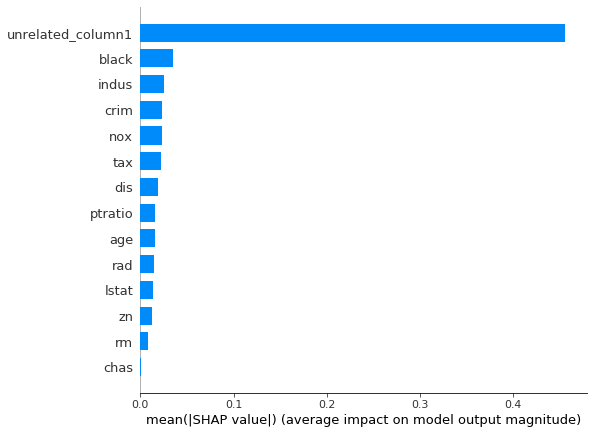

---------------------


We are using a perturbation multiplier of 5


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.06299212598425197), ('age', 0.03937007874015748), ('black', 0.4566929133858268), ('crim', 0.11811023622047244), ('dis', 0.023622047244094488), ('indus', 0.05511811023622047), ('lstat', 0.03937007874015748), ('nox', 0.03937007874015748), ('ptratio', 0.047244094488188976), ('rad', 0.007874015748031496), ('rm', 0.015748031496062992), ('tax', 0.07874015748031496), ('zn', 0.015748031496062992)], 3: [('Nothing shown', 0.1889763779527559), ('age', 0.07086614173228346), ('black', 0.047244094488188976), ('crim', 0.2283464566929134), ('dis', 0.015748031496062992), ('indus', 0.11811023622047244), ('lstat', 0.031496062992125984), ('nox', 0.14173228346456693), ('ptratio', 0.03937007874015748), ('rad', 0.015748031496062992), ('rm', 0.007874015748031496), ('tax', 0.06299212598425197), ('zn', 0.031496062992125984)]}
Fidelity: 0.87
---------------------


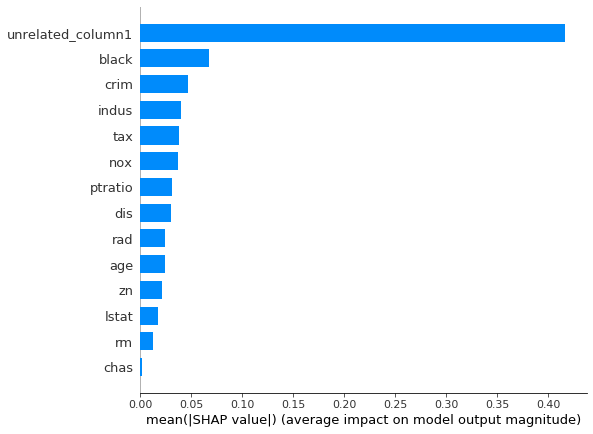

---------------------


We are using a perturbation multiplier of 10


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.047244094488188976), ('age', 0.031496062992125984), ('black', 0.4881889763779528), ('crim', 0.11023622047244094), ('dis', 0.05511811023622047), ('indus', 0.03937007874015748), ('lstat', 0.015748031496062992), ('nox', 0.07086614173228346), ('ptratio', 0.031496062992125984), ('rm', 0.015748031496062992), ('tax', 0.09448818897637795)], 3: [('Nothing shown', 0.14960629921259844), ('age', 0.11023622047244094), ('black', 0.007874015748031496), ('crim', 0.29133858267716534), ('dis', 0.047244094488188976), ('indus', 0.11023622047244094), ('lstat', 0.015748031496062992), ('nox', 0.05511811023622047), ('ptratio', 0.03937007874015748), ('rad', 0.007874015748031496), ('tax', 0.11023622047244094), ('zn', 0.05511811023622047)]}
Fidelity: 0.91
---------------------


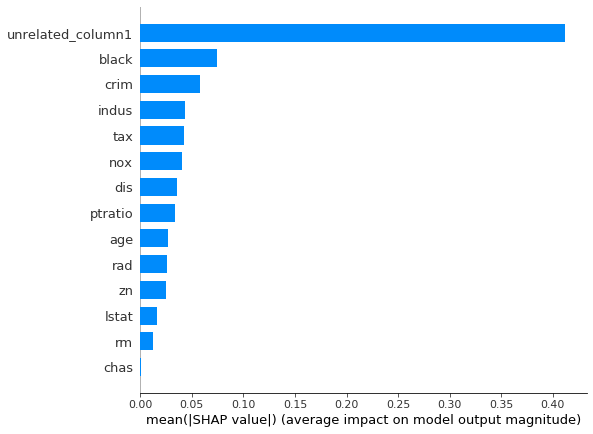

---------------------


We are using a perturbation multiplier of 50


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.05511811023622047), ('black', 0.5118110236220472), ('chas', 0.007874015748031496), ('crim', 0.11023622047244094), ('dis', 0.015748031496062992), ('indus', 0.08661417322834646), ('lstat', 0.031496062992125984), ('nox', 0.015748031496062992), ('ptratio', 0.03937007874015748), ('rad', 0.007874015748031496), ('rm', 0.015748031496062992), ('tax', 0.06299212598425197), ('zn', 0.03937007874015748)], 3: [('Nothing shown', 0.031496062992125984), ('age', 0.031496062992125984), ('black', 0.07874015748031496), ('chas', 0.007874015748031496), ('crim', 0.1732283464566929), ('dis', 0.11811023622047244), ('indus', 0.12598425196850394), ('lstat', 0.015748031496062992), ('nox', 0.10236220472440945), ('ptratio', 0.08661417322834646), ('rad', 0.015748031496062992), ('rm', 0.031496062992125984), ('tax', 0.11811023622047244), ('zn', 0.06299212598425197)]}
Fidelity: 0.88
---------------------


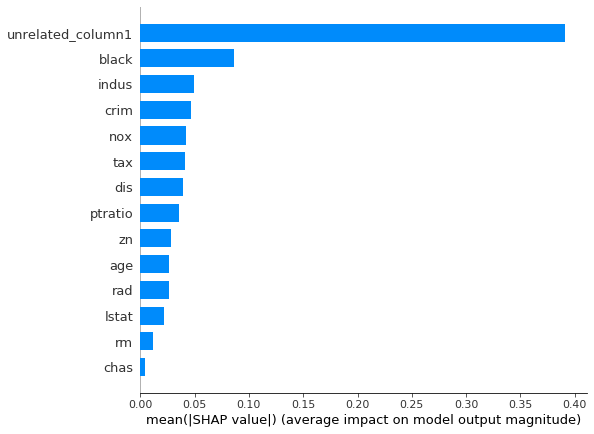

---------------------


We are using a perturbation multiplier of 100


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.023622047244094488), ('black', 0.5196850393700787), ('chas', 0.007874015748031496), ('crim', 0.06299212598425197), ('dis', 0.023622047244094488), ('indus', 0.07086614173228346), ('lstat', 0.015748031496062992), ('nox', 0.05511811023622047), ('ptratio', 0.03937007874015748), ('rad', 0.031496062992125984), ('rm', 0.03937007874015748), ('tax', 0.05511811023622047), ('zn', 0.05511811023622047)], 3: [('Nothing shown', 0.031496062992125984), ('age', 0.047244094488188976), ('black', 0.05511811023622047), ('chas', 0.015748031496062992), ('crim', 0.13385826771653545), ('dis', 0.07874015748031496), ('indus', 0.1968503937007874), ('lstat', 0.007874015748031496), ('nox', 0.09448818897637795), ('ptratio', 0.08661417322834646), ('rad', 0.05511811023622047), ('rm', 0.031496062992125984), ('tax', 0.09448818897637795), ('zn', 0.07086614173228346)]}
Fidelity: 0.91
---------------------


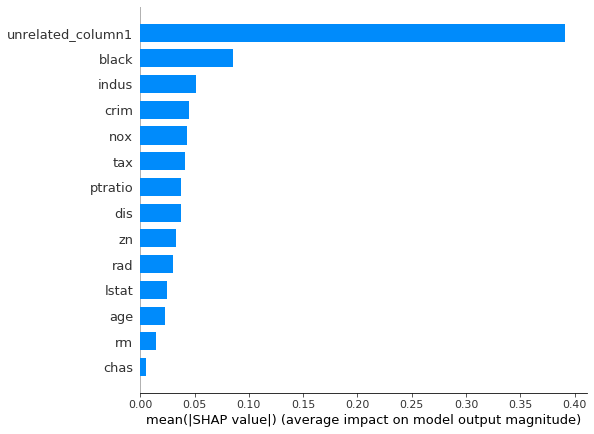

---------------------


We are using a perturbation multiplier of 200


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.007874015748031496), ('black', 0.5039370078740157), ('chas', 0.007874015748031496), ('crim', 0.11023622047244094), ('dis', 0.031496062992125984), ('indus', 0.047244094488188976), ('lstat', 0.023622047244094488), ('nox', 0.05511811023622047), ('ptratio', 0.03937007874015748), ('rad', 0.023622047244094488), ('rm', 0.023622047244094488), ('tax', 0.08661417322834646), ('zn', 0.03937007874015748)], 3: [('Nothing shown', 0.023622047244094488), ('age', 0.03937007874015748), ('black', 0.07086614173228346), ('chas', 0.007874015748031496), ('crim', 0.14960629921259844), ('dis', 0.11811023622047244), ('indus', 0.16535433070866143), ('lstat', 0.05511811023622047), ('nox', 0.07874015748031496), ('ptratio', 0.07086614173228346), ('rad', 0.07874015748031496), ('rm', 0.007874015748031496), ('tax', 0.07874015748031496), ('zn', 0.05511811023622047)]}
Fidelity: 0.9
---------------------


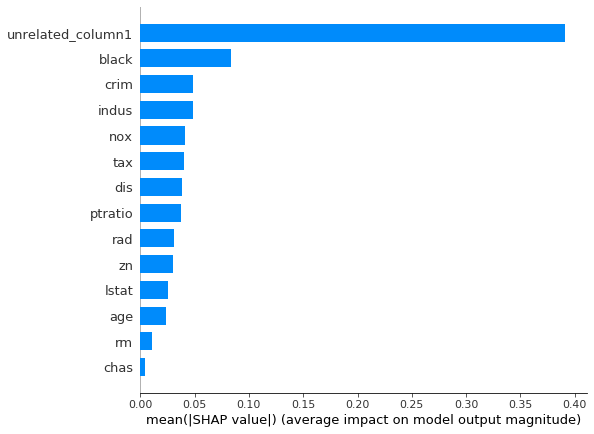

---------------------


---------------------
Iteration: 3 ; Used seed: 4079763255
---------------------

We are using a perturbation multiplier of 1


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.4409448818897638), ('age', 0.023622047244094488), ('black', 0.12598425196850394), ('crim', 0.015748031496062992), ('dis', 0.10236220472440945), ('lstat', 0.031496062992125984), ('nox', 0.11811023622047244), ('ptratio', 0.015748031496062992), ('rad', 0.007874015748031496), ('rm', 0.08661417322834646), ('tax', 0.023622047244094488), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.5669291338582677), ('age', 0.08661417322834646), ('black', 0.03937007874015748), ('crim', 0.047244094488188976), ('dis', 0.07874015748031496), ('indus', 0.023622047244094488), ('lstat', 0.007874015748031496), ('nox', 0.047244094488188976), ('ptratio', 0.015748031496062992), ('rad', 0.015748031496062992), ('rm', 0.031496062992125984), ('tax', 0.031496062992125984), ('zn', 0.007874015748031496)]}
Fidelity: 0.61
---------------------


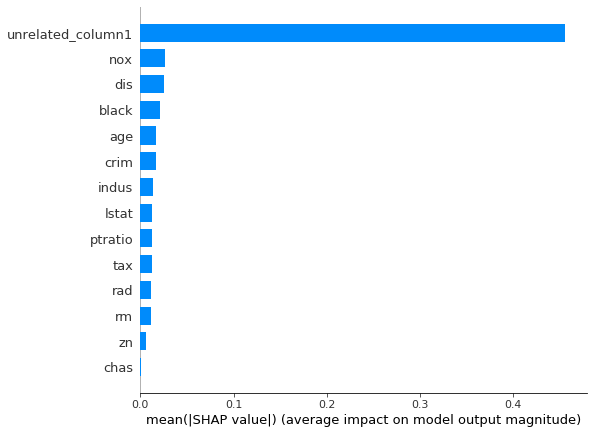

---------------------


We are using a perturbation multiplier of 5


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.07086614173228346), ('black', 0.4015748031496063), ('crim', 0.05511811023622047), ('dis', 0.08661417322834646), ('indus', 0.015748031496062992), ('lstat', 0.023622047244094488), ('nox', 0.047244094488188976), ('ptratio', 0.09448818897637795), ('rad', 0.06299212598425197), ('rm', 0.007874015748031496), ('tax', 0.07874015748031496), ('zn', 0.05511811023622047)], 3: [('age', 0.11023622047244094), ('black', 0.08661417322834646), ('crim', 0.10236220472440945), ('dis', 0.10236220472440945), ('indus', 0.03937007874015748), ('lstat', 0.031496062992125984), ('nox', 0.08661417322834646), ('ptratio', 0.07874015748031496), ('rad', 0.11811023622047244), ('rm', 0.023622047244094488), ('tax', 0.15748031496062992), ('zn', 0.06299212598425197)]}
Fidelity: 0.84
---------------------


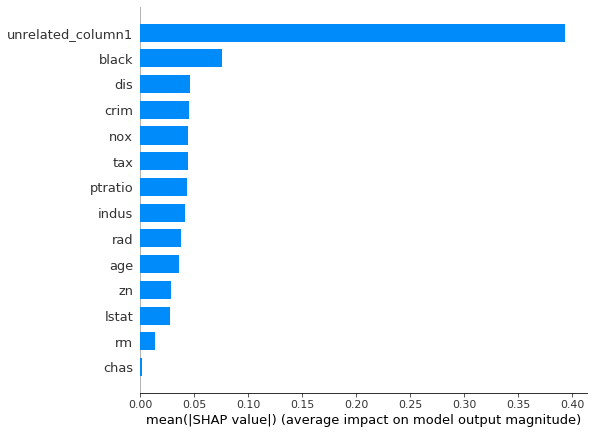

---------------------


We are using a perturbation multiplier of 10


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.05511811023622047), ('unrelated_column1', 0.9448818897637795)], 2: [('age', 0.07086614173228346), ('black', 0.36220472440944884), ('crim', 0.06299212598425197), ('dis', 0.047244094488188976), ('indus', 0.031496062992125984), ('lstat', 0.047244094488188976), ('nox', 0.015748031496062992), ('ptratio', 0.08661417322834646), ('rad', 0.05511811023622047), ('rm', 0.015748031496062992), ('tax', 0.12598425196850394), ('unrelated_column1', 0.05511811023622047), ('zn', 0.023622047244094488)], 3: [('age', 0.047244094488188976), ('black', 0.08661417322834646), ('crim', 0.11811023622047244), ('dis', 0.06299212598425197), ('indus', 0.08661417322834646), ('lstat', 0.05511811023622047), ('nox', 0.031496062992125984), ('ptratio', 0.09448818897637795), ('rad', 0.18110236220472442), ('rm', 0.023622047244094488), ('tax', 0.15748031496062992), ('zn', 0.05511811023622047)]}
Fidelity: 0.87
---------------------


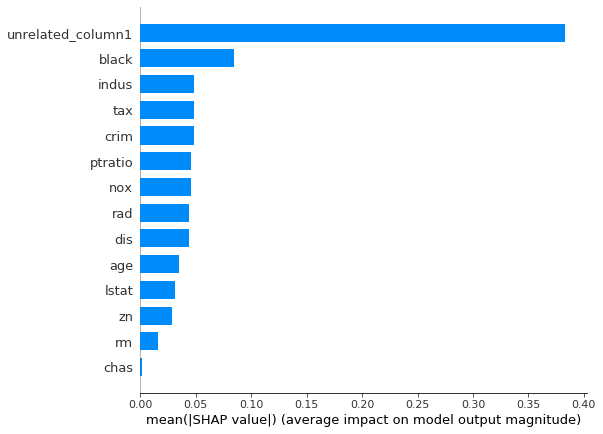

---------------------


We are using a perturbation multiplier of 50


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.047244094488188976), ('unrelated_column1', 0.952755905511811)], 2: [('age', 0.06299212598425197), ('black', 0.3937007874015748), ('crim', 0.07086614173228346), ('dis', 0.007874015748031496), ('indus', 0.015748031496062992), ('nox', 0.015748031496062992), ('ptratio', 0.16535433070866143), ('rad', 0.07086614173228346), ('rm', 0.023622047244094488), ('tax', 0.09448818897637795), ('unrelated_column1', 0.047244094488188976), ('zn', 0.031496062992125984)], 3: [('age', 0.047244094488188976), ('black', 0.13385826771653545), ('crim', 0.11811023622047244), ('dis', 0.10236220472440945), ('indus', 0.06299212598425197), ('lstat', 0.05511811023622047), ('nox', 0.06299212598425197), ('ptratio', 0.09448818897637795), ('rad', 0.16535433070866143), ('rm', 0.007874015748031496), ('tax', 0.11023622047244094), ('zn', 0.03937007874015748)]}
Fidelity: 0.89
---------------------


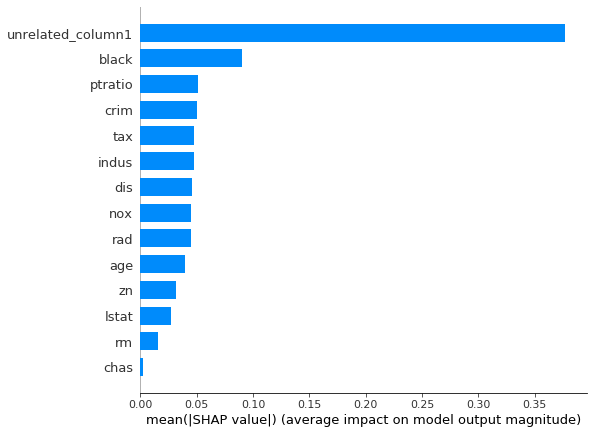

---------------------


We are using a perturbation multiplier of 100


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.05511811023622047), ('unrelated_column1', 0.9448818897637795)], 2: [('age', 0.031496062992125984), ('black', 0.4330708661417323), ('crim', 0.07086614173228346), ('dis', 0.023622047244094488), ('indus', 0.007874015748031496), ('nox', 0.015748031496062992), ('ptratio', 0.16535433070866143), ('rad', 0.06299212598425197), ('rm', 0.015748031496062992), ('tax', 0.09448818897637795), ('unrelated_column1', 0.05511811023622047), ('zn', 0.023622047244094488)], 3: [('age', 0.047244094488188976), ('black', 0.08661417322834646), ('crim', 0.10236220472440945), ('dis', 0.03937007874015748), ('indus', 0.12598425196850394), ('lstat', 0.047244094488188976), ('nox', 0.07086614173228346), ('ptratio', 0.14960629921259844), ('rad', 0.11023622047244094), ('tax', 0.15748031496062992), ('zn', 0.06299212598425197)]}
Fidelity: 0.9
---------------------


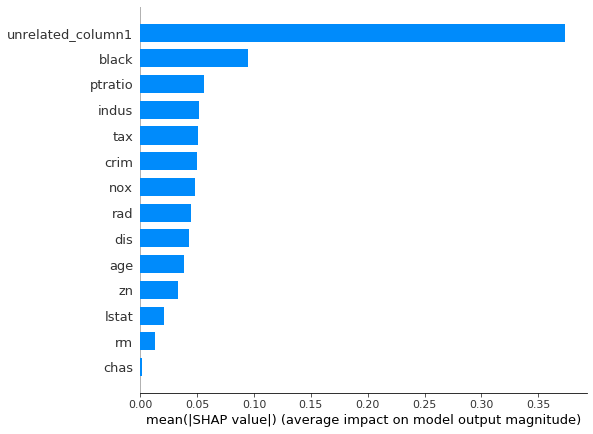

---------------------


We are using a perturbation multiplier of 200


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.03937007874015748), ('unrelated_column1', 0.9606299212598425)], 2: [('age', 0.06299212598425197), ('black', 0.4566929133858268), ('crim', 0.047244094488188976), ('dis', 0.007874015748031496), ('indus', 0.03937007874015748), ('nox', 0.015748031496062992), ('ptratio', 0.14173228346456693), ('rad', 0.047244094488188976), ('rm', 0.031496062992125984), ('tax', 0.07874015748031496), ('unrelated_column1', 0.03937007874015748), ('zn', 0.031496062992125984)], 3: [('age', 0.05511811023622047), ('black', 0.047244094488188976), ('crim', 0.09448818897637795), ('dis', 0.06299212598425197), ('indus', 0.12598425196850394), ('lstat', 0.05511811023622047), ('nox', 0.047244094488188976), ('ptratio', 0.12598425196850394), ('rad', 0.18110236220472442), ('tax', 0.12598425196850394), ('zn', 0.07874015748031496)]}
Fidelity: 0.88
---------------------


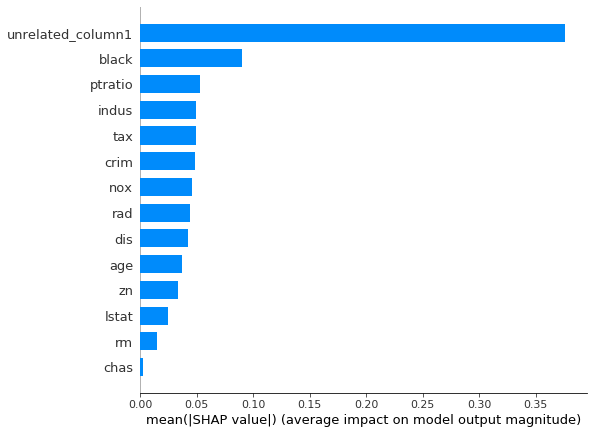

---------------------




In [114]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for pm in [1,5,10,50,100,200]:
        print ("We are using a perturbation multiplier of", pm)
        fools.SHAP_execute(perturbation_multiplier=pm)
        print("---------------------\n\n")

### Changing the number of random forest estimators
We observe that:<br>
The amount of random forest estimators has no significant influence regarding fidility, importance of the sensitive feature on a specific rank or the overall importance of the sensitive feature.<br>
The model successfully shifted the importance from the sensitive feature to the chosen feature on the 1st rank.<br>

---------------------
Iteration: 1 ; Used seed: 604059657
---------------------

We are using 10 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('age', 0.023622047244094488), ('black', 0.41732283464566927), ('chas', 0.015748031496062992), ('crim', 0.14960629921259844), ('dis', 0.047244094488188976), ('indus', 0.007874015748031496), ('lstat', 0.023622047244094488), ('nox', 0.11811023622047244), ('ptratio', 0.07086614173228346), ('rm', 0.015748031496062992), ('tax', 0.08661417322834646), ('unrelated_column1', 0.023622047244094488)], 3: [('Nothing shown', 0.007874015748031496), ('age', 0.06299212598425197), ('black', 0.047244094488188976), ('crim', 0.14173228346456693), ('dis', 0.03937007874015748), ('indus', 0.08661417322834646), ('lstat', 0.05511811023622047), ('nox', 0.09448818897637795), ('ptratio', 0.1889763779527559), ('rad', 0.11023622047244094), ('rm', 0.007874015748031496), ('tax', 0.12598425196850394), ('zn', 0.031496062992125984)]}
Fidelity: 0.87
---------------------


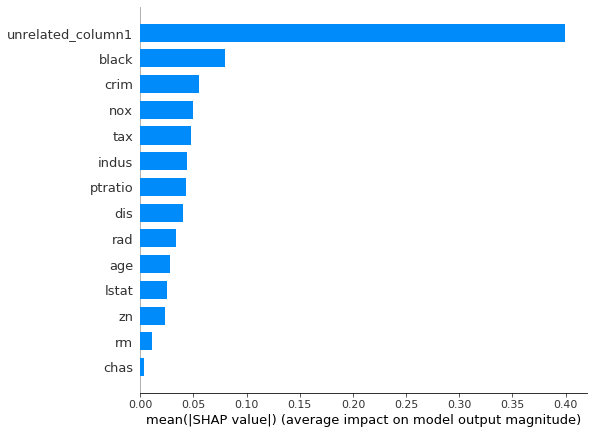

---------------------


We are using 50 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('black', 0.41732283464566927), ('crim', 0.06299212598425197), ('dis', 0.015748031496062992), ('indus', 0.08661417322834646), ('lstat', 0.10236220472440945), ('nox', 0.047244094488188976), ('ptratio', 0.07874015748031496), ('rad', 0.007874015748031496), ('rm', 0.023622047244094488), ('tax', 0.10236220472440945), ('unrelated_column1', 0.023622047244094488), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.047244094488188976), ('age', 0.015748031496062992), ('black', 0.05511811023622047), ('crim', 0.11811023622047244), ('dis', 0.06299212598425197), ('indus', 0.12598425196850394), ('lstat', 0.11023622047244094), ('nox', 0.11023622047244094), ('ptratio', 0.15748031496062992), ('rad', 0.031496062992125984), ('tax', 0.14173228346456693), ('zn', 0.023622047244094488)]}
Fidelity: 0.86
---------------------


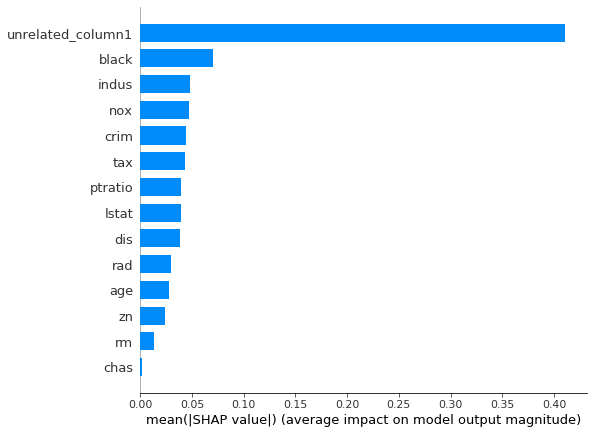

---------------------


We are using 100 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('age', 0.015748031496062992), ('black', 0.3779527559055118), ('crim', 0.07086614173228346), ('dis', 0.03937007874015748), ('indus', 0.06299212598425197), ('lstat', 0.08661417322834646), ('nox', 0.07874015748031496), ('ptratio', 0.07874015748031496), ('rad', 0.05511811023622047), ('rm', 0.007874015748031496), ('tax', 0.10236220472440945), ('unrelated_column1', 0.023622047244094488)], 3: [('Nothing shown', 0.031496062992125984), ('age', 0.047244094488188976), ('black', 0.07086614173228346), ('crim', 0.14960629921259844), ('dis', 0.031496062992125984), ('indus', 0.11811023622047244), ('lstat', 0.07086614173228346), ('nox', 0.047244094488188976), ('ptratio', 0.16535433070866143), ('rad', 0.09448818897637795), ('rm', 0.007874015748031496), ('tax', 0.13385826771653545), ('zn', 0.031496062992125984)]}
Fidelity: 0.91
---------------------


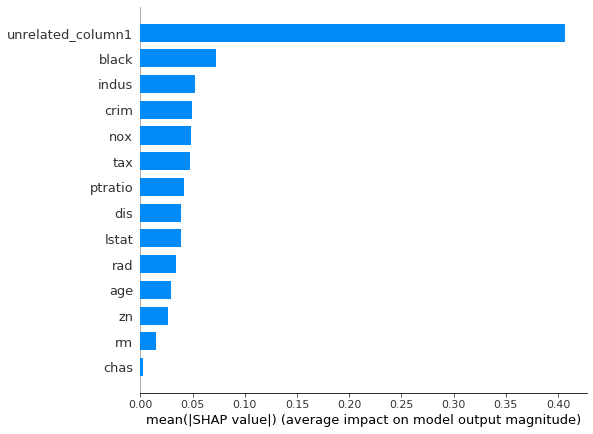

---------------------


We are using 200 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('age', 0.015748031496062992), ('black', 0.4251968503937008), ('crim', 0.06299212598425197), ('indus', 0.08661417322834646), ('lstat', 0.07874015748031496), ('nox', 0.047244094488188976), ('ptratio', 0.10236220472440945), ('rad', 0.023622047244094488), ('rm', 0.031496062992125984), ('tax', 0.08661417322834646), ('unrelated_column1', 0.023622047244094488), ('zn', 0.015748031496062992)], 3: [('Nothing shown', 0.03937007874015748), ('age', 0.047244094488188976), ('black', 0.07874015748031496), ('crim', 0.1732283464566929), ('dis', 0.03937007874015748), ('indus', 0.07874015748031496), ('lstat', 0.07874015748031496), ('nox', 0.10236220472440945), ('ptratio', 0.12598425196850394), ('rad', 0.07086614173228346), ('rm', 0.007874015748031496), ('tax', 0.13385826771653545), ('zn', 0.023622047244094488)]}
Fidelity: 0.87
---------------------


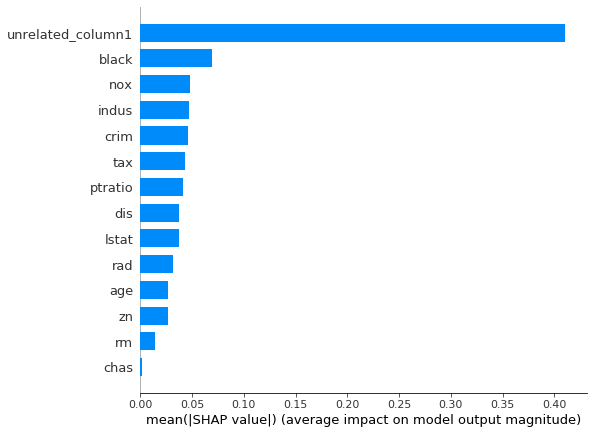

---------------------


We are using 500 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('age', 0.015748031496062992), ('black', 0.4015748031496063), ('crim', 0.03937007874015748), ('dis', 0.031496062992125984), ('indus', 0.08661417322834646), ('lstat', 0.07874015748031496), ('nox', 0.06299212598425197), ('ptratio', 0.08661417322834646), ('rad', 0.023622047244094488), ('rm', 0.007874015748031496), ('tax', 0.12598425196850394), ('unrelated_column1', 0.023622047244094488), ('zn', 0.015748031496062992)], 3: [('Nothing shown', 0.047244094488188976), ('age', 0.05511811023622047), ('black', 0.10236220472440945), ('crim', 0.11023622047244094), ('dis', 0.047244094488188976), ('indus', 0.07874015748031496), ('lstat', 0.07086614173228346), ('nox', 0.06299212598425197), ('ptratio', 0.15748031496062992), ('rad', 0.10236220472440945), ('rm', 0.015748031496062992), ('tax', 0.11023622047244094), ('zn', 0.03937007874015748)]}
Fidelity: 0.89
---------

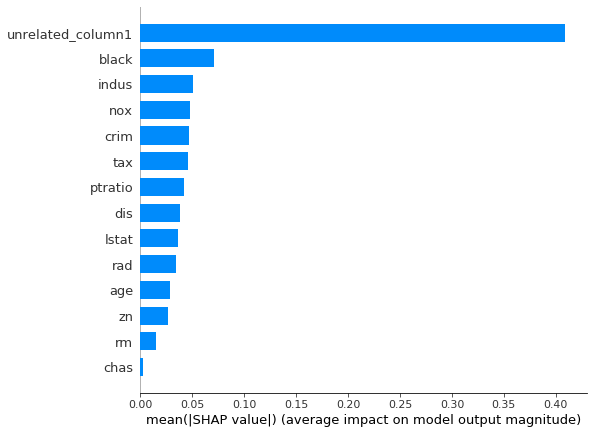

---------------------


---------------------
Iteration: 2 ; Used seed: 797215153
---------------------

We are using 10 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.031496062992125984), ('age', 0.07874015748031496), ('black', 0.3700787401574803), ('crim', 0.1732283464566929), ('dis', 0.05511811023622047), ('indus', 0.007874015748031496), ('lstat', 0.10236220472440945), ('nox', 0.015748031496062992), ('ptratio', 0.007874015748031496), ('tax', 0.15748031496062992)], 3: [('Nothing shown', 0.14173228346456693), ('age', 0.07086614173228346), ('black', 0.05511811023622047), ('crim', 0.1968503937007874), ('dis', 0.11023622047244094), ('indus', 0.06299212598425197), ('lstat', 0.13385826771653545), ('nox', 0.047244094488188976), ('ptratio', 0.05511811023622047), ('rad', 0.007874015748031496), ('tax', 0.08661417322834646), ('zn', 0.031496062992125984)]}
Fidelity: 0.94
---------------------


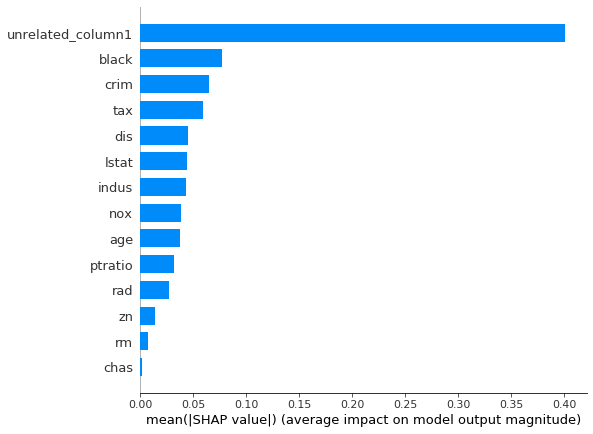

---------------------


We are using 50 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.08661417322834646), ('age', 0.09448818897637795), ('black', 0.36220472440944884), ('crim', 0.11023622047244094), ('dis', 0.031496062992125984), ('lstat', 0.03937007874015748), ('nox', 0.031496062992125984), ('ptratio', 0.031496062992125984), ('rad', 0.007874015748031496), ('rm', 0.007874015748031496), ('tax', 0.1732283464566929), ('zn', 0.023622047244094488)], 3: [('Nothing shown', 0.2204724409448819), ('age', 0.10236220472440945), ('black', 0.03937007874015748), ('crim', 0.18110236220472442), ('dis', 0.047244094488188976), ('indus', 0.047244094488188976), ('lstat', 0.11023622047244094), ('nox', 0.07086614173228346), ('ptratio', 0.03937007874015748), ('rad', 0.007874015748031496), ('tax', 0.10236220472440945), ('zn', 0.031496062992125984)]}
Fidelity: 0.91
---------------------


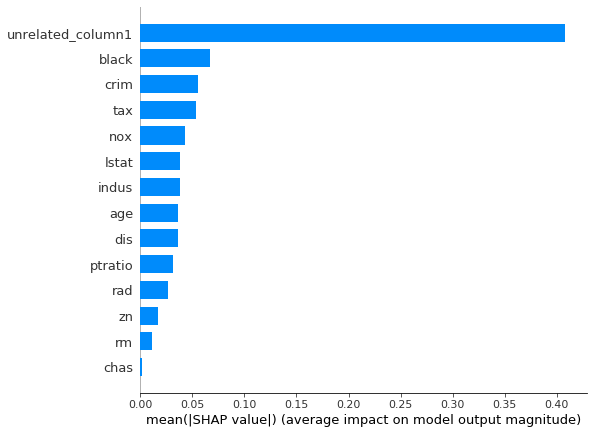

---------------------


We are using 100 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.031496062992125984), ('black', 0.3700787401574803), ('crim', 0.12598425196850394), ('dis', 0.015748031496062992), ('indus', 0.07874015748031496), ('lstat', 0.023622047244094488), ('nox', 0.031496062992125984), ('ptratio', 0.023622047244094488), ('rad', 0.05511811023622047), ('tax', 0.2125984251968504), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.08661417322834646), ('age', 0.015748031496062992), ('black', 0.03937007874015748), ('crim', 0.28346456692913385), ('dis', 0.07086614173228346), ('indus', 0.07086614173228346), ('lstat', 0.023622047244094488), ('nox', 0.07086614173228346), ('ptratio', 0.07086614173228346), ('rad', 0.05511811023622047), ('rm', 0.015748031496062992), ('tax', 0.18110236220472442), ('zn', 0.015748031496062992)]}
Fidelity: 0.91
---------------------


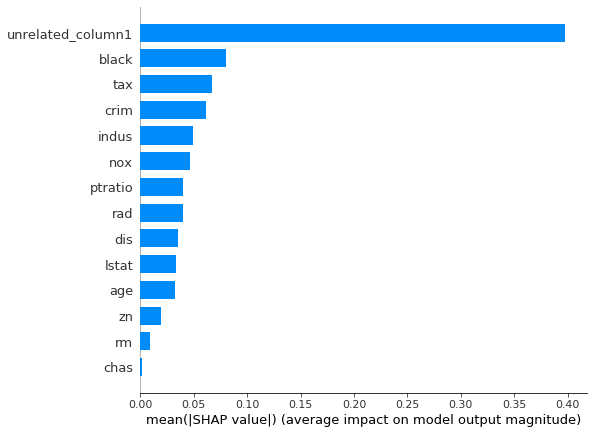

---------------------


We are using 200 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('black', 0.3858267716535433), ('crim', 0.14173228346456693), ('dis', 0.031496062992125984), ('indus', 0.03937007874015748), ('lstat', 0.031496062992125984), ('nox', 0.031496062992125984), ('ptratio', 0.03937007874015748), ('rad', 0.007874015748031496), ('rm', 0.007874015748031496), ('tax', 0.25984251968503935), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.10236220472440945), ('age', 0.031496062992125984), ('black', 0.047244094488188976), ('crim', 0.18110236220472442), ('dis', 0.07874015748031496), ('indus', 0.09448818897637795), ('lstat', 0.023622047244094488), ('nox', 0.06299212598425197), ('ptratio', 0.11023622047244094), ('rad', 0.10236220472440945), ('tax', 0.14173228346456693), ('zn', 0.023622047244094488)]}
Fidelity: 0.91
---------------------


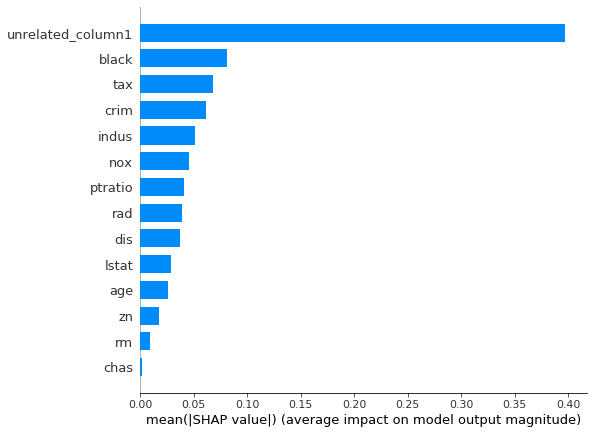

---------------------


We are using 500 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('black', 0.3937007874015748), ('crim', 0.11023622047244094), ('dis', 0.007874015748031496), ('indus', 0.06299212598425197), ('lstat', 0.047244094488188976), ('nox', 0.03937007874015748), ('ptratio', 0.031496062992125984), ('rad', 0.023622047244094488), ('tax', 0.25984251968503935), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.10236220472440945), ('age', 0.031496062992125984), ('black', 0.023622047244094488), ('crim', 0.18110236220472442), ('dis', 0.05511811023622047), ('indus', 0.12598425196850394), ('lstat', 0.031496062992125984), ('nox', 0.11023622047244094), ('ptratio', 0.07086614173228346), ('rad', 0.10236220472440945), ('rm', 0.023622047244094488), ('tax', 0.12598425196850394), ('zn', 0.015748031496062992)]}
Fidelity: 0.91
---------------------


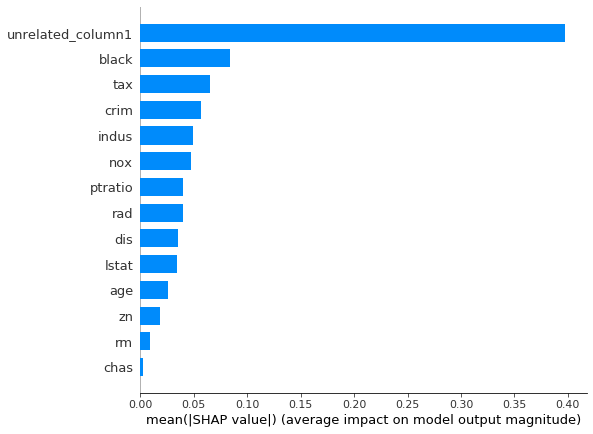

---------------------


---------------------
Iteration: 3 ; Used seed: 420694146
---------------------

We are using 10 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.09448818897637795), ('indus', 0.007874015748031496), ('nox', 0.007874015748031496), ('rad', 0.007874015748031496), ('unrelated_column1', 0.8740157480314961), ('zn', 0.007874015748031496)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.023622047244094488), ('black', 0.5433070866141733), ('crim', 0.047244094488188976), ('dis', 0.007874015748031496), ('indus', 0.047244094488188976), ('nox', 0.07874015748031496), ('ptratio', 0.023622047244094488), ('rad', 0.031496062992125984), ('rm', 0.031496062992125984), ('tax', 0.03937007874015748), ('unrelated_column1', 0.10236220472440945), ('zn', 0.015748031496062992)], 3: [('Nothing shown', 0.11811023622047244), ('age', 0.047244094488188976), ('black', 0.08661417322834646), ('crim', 0.08661417322834646), ('dis', 0.031496062992125984), ('indus', 0.12598425196850394), ('lstat', 0.047244094488188976), ('nox', 0.07874015748031496), ('ptratio', 0.09448818897637795), ('rad', 

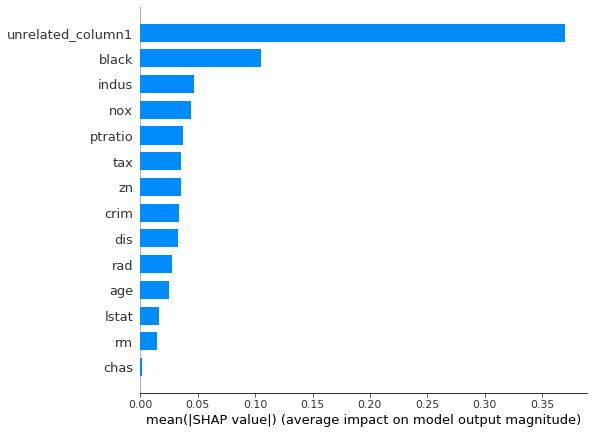

---------------------


We are using 50 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.047244094488188976), ('unrelated_column1', 0.952755905511811)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.015748031496062992), ('black', 0.5826771653543307), ('crim', 0.06299212598425197), ('indus', 0.031496062992125984), ('lstat', 0.015748031496062992), ('nox', 0.06299212598425197), ('ptratio', 0.047244094488188976), ('rad', 0.015748031496062992), ('rm', 0.031496062992125984), ('tax', 0.031496062992125984), ('unrelated_column1', 0.047244094488188976), ('zn', 0.047244094488188976)], 3: [('Nothing shown', 0.14173228346456693), ('age', 0.031496062992125984), ('black', 0.10236220472440945), ('crim', 0.047244094488188976), ('dis', 0.047244094488188976), ('indus', 0.11023622047244094), ('lstat', 0.07086614173228346), ('nox', 0.07874015748031496), ('ptratio', 0.07874015748031496), ('rad', 0.031496062992125984), ('tax', 0.07874015748031496), ('zn', 0.18110236220472442)]}
Fidelity: 0.85
---------------------


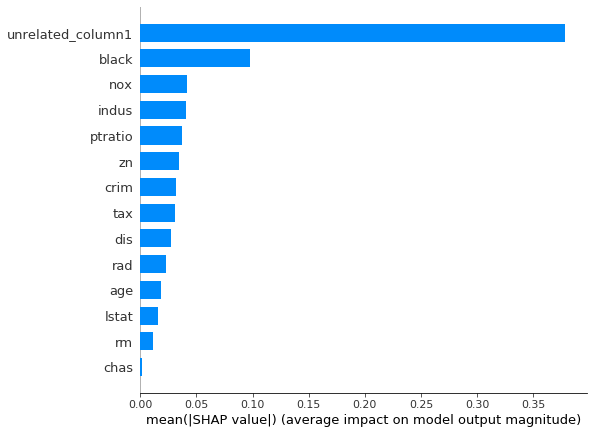

---------------------


We are using 100 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.03937007874015748), ('unrelated_column1', 0.9606299212598425)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.031496062992125984), ('black', 0.6220472440944882), ('crim', 0.06299212598425197), ('dis', 0.015748031496062992), ('indus', 0.031496062992125984), ('nox', 0.031496062992125984), ('ptratio', 0.047244094488188976), ('rad', 0.023622047244094488), ('rm', 0.023622047244094488), ('tax', 0.031496062992125984), ('unrelated_column1', 0.03937007874015748), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.14173228346456693), ('age', 0.03937007874015748), ('black', 0.07086614173228346), ('crim', 0.09448818897637795), ('dis', 0.07874015748031496), ('indus', 0.11023622047244094), ('lstat', 0.05511811023622047), ('nox', 0.05511811023622047), ('ptratio', 0.07874015748031496), ('rad', 0.031496062992125984), ('rm', 0.015748031496062992), ('tax', 0.05511811023622047), ('zn', 0.1732283464566929)]}
Fidelity: 0.86


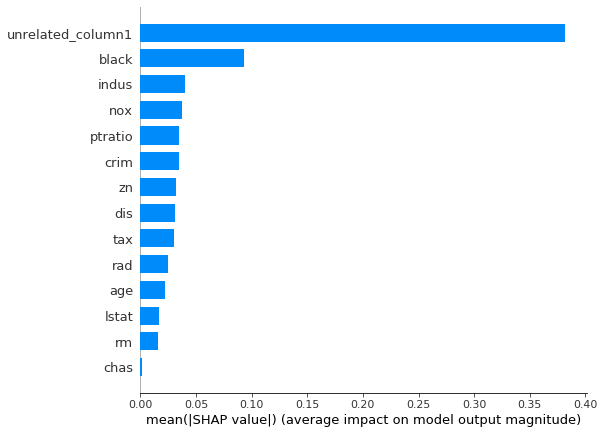

---------------------


We are using 200 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.03937007874015748), ('unrelated_column1', 0.9606299212598425)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.03937007874015748), ('black', 0.6220472440944882), ('crim', 0.023622047244094488), ('dis', 0.015748031496062992), ('indus', 0.047244094488188976), ('lstat', 0.015748031496062992), ('nox', 0.031496062992125984), ('ptratio', 0.06299212598425197), ('rm', 0.023622047244094488), ('tax', 0.03937007874015748), ('unrelated_column1', 0.03937007874015748), ('zn', 0.031496062992125984)], 3: [('Nothing shown', 0.12598425196850394), ('age', 0.11023622047244094), ('black', 0.05511811023622047), ('crim', 0.11811023622047244), ('dis', 0.023622047244094488), ('indus', 0.11023622047244094), ('lstat', 0.031496062992125984), ('nox', 0.13385826771653545), ('ptratio', 0.11023622047244094), ('rad', 0.047244094488188976), ('rm', 0.007874015748031496), ('tax', 0.05511811023622047), ('zn', 0.07086614173228346)]}
Fidelity: 0.

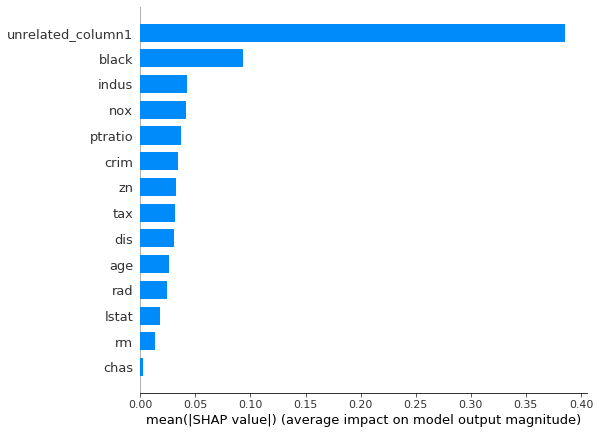

---------------------


We are using 500 random forest multipliers


  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.06299212598425197), ('unrelated_column1', 0.937007874015748)], 2: [('Nothing shown', 0.007874015748031496), ('age', 0.03937007874015748), ('black', 0.5433070866141733), ('crim', 0.03937007874015748), ('dis', 0.007874015748031496), ('indus', 0.05511811023622047), ('lstat', 0.031496062992125984), ('nox', 0.06299212598425197), ('ptratio', 0.05511811023622047), ('rm', 0.007874015748031496), ('tax', 0.031496062992125984), ('unrelated_column1', 0.06299212598425197), ('zn', 0.05511811023622047)], 3: [('Nothing shown', 0.15748031496062992), ('age', 0.05511811023622047), ('black', 0.08661417322834646), ('crim', 0.07086614173228346), ('dis', 0.05511811023622047), ('indus', 0.11023622047244094), ('lstat', 0.03937007874015748), ('nox', 0.06299212598425197), ('ptratio', 0.09448818897637795), ('rad', 0.047244094488188976), ('rm', 0.023622047244094488), ('tax', 0.05511811023622047), ('zn', 0.14173228346456693)]}
Fidelity: 0.87
---

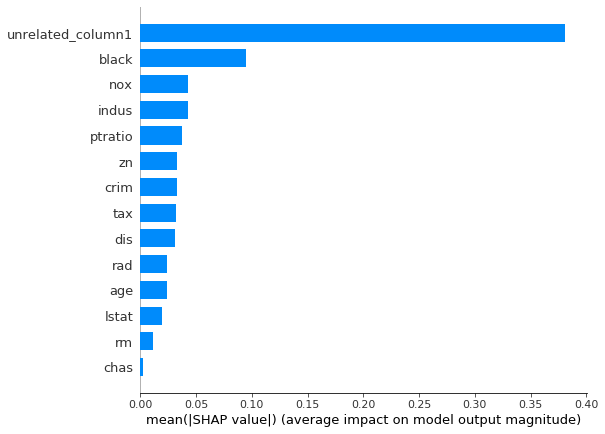

---------------------




In [115]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    for rf in [10,50,100,200,500]:
        print ("We are using", rf, "random forest multipliers")
        fools.SHAP_execute(rf_estimators=rf)
        print("---------------------\n\n")

## Testing Perturbation Methods for LIME
In addition to the standard perturbation method we also introduce two other perturbation methods.

### Changing Perturbation Method to Soft Brownian Offset
The change to SBO does not really have an impact on LIME results. Fidility is the same, importance of the sensitive feature does not change significantly, and the sensitive features influence is successfully shifted towards the chosen feature.

In [116]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh, perturbation_lime_mode=PERTURB_LIME_MODE_SBO)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _, _ = fools.LIME_execute()
    print("---------------------\n\n")

---------------------
Iteration: 1 ; Used seed: 2805623359
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('age', 0.015748031496062992), ('chas', 0.8267716535433071), ('crim', 0.031496062992125984), ('dis', 0.015748031496062992), ('indus', 0.023622047244094488), ('lstat', 0.007874015748031496), ('nox', 0.007874015748031496), ('ptratio', 0.015748031496062992), ('rad', 0.007874015748031496), ('rm', 0.023622047244094488), ('tax', 0.007874015748031496), ('zn', 0.015748031496062992)], 3: [('age', 0.07874015748031496), ('black', 0.08661417322834646), ('chas', 0.015748031496062992), ('crim', 0.05511811023622047), ('dis', 0.11023622047244094), ('indus', 0.07874015748031496), ('lstat', 0.05511811023622047), ('nox', 0.06299212598425197), ('ptratio', 0.07086614173228346), ('rad', 0.07086614173228346), ('rm', 0.07086614173228346), ('tax', 0.13385826771653545), ('zn', 0.11023622047244094

### Changing Perturbation Method to Gaussian Hyperspheric Offset
Fidility is the same when using GHO. However, the sensitive feature's influence is significantly higher than in the standard approach. This can especially be seen in the 2nd and 3rd feature rank, while the 1st feature rank is mostly unaffected.

In [118]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh, perturbation_lime_mode=PERTURB_LIME_MODE_GHO)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _, _ = fools.LIME_execute()
    print("---------------------\n\n")

---------------------
Iteration: 1 ; Used seed: 2368574817
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('black', 0.023622047244094488), ('unrelated_column1', 0.9763779527559056)], 2: [('age', 0.2440944881889764), ('black', 0.4015748031496063), ('chas', 0.05511811023622047), ('crim', 0.007874015748031496), ('indus', 0.09448818897637795), ('ptratio', 0.03937007874015748), ('rad', 0.06299212598425197), ('rm', 0.015748031496062992), ('tax', 0.05511811023622047), ('unrelated_column1', 0.023622047244094488)], 3: [('age', 0.16535433070866143), ('black', 0.29133858267716534), ('chas', 0.07874015748031496), ('dis', 0.05511811023622047), ('indus', 0.09448818897637795), ('lstat', 0.023622047244094488), ('ptratio', 0.09448818897637795), ('rad', 0.10236220472440945), ('rm', 0.03937007874015748), ('tax', 0.047244094488188976), ('zn', 0.007874015748031496)]}
Fidelity: 1.0
---------------------


---------------------
I

## Testing Perturbation Methods for SHAP
In addition to the standard perturbation method we also introduce another perturbation method.

### Changing Perturbation Method to BIRCH
The fidility is slightly lower compared to when we use the standard approach. Also, the 1st rank feature is still the chosen feature but the sensitive feature is still unusual high up with it. In addition to that the sensitive feature is a very influencial feature on the 2nd feature rank. In total it is roughly half as influencial as the chosen feature.

---------------------
Iteration: 1 ; Used seed: 776577456
---------------------



  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.1889763779527559), ('lstat', 0.023622047244094488), ('unrelated_column1', 0.7874015748031497)], 2: [('Nothing shown', 0.07086614173228346), ('age', 0.015748031496062992), ('black', 0.5905511811023622), ('crim', 0.015748031496062992), ('dis', 0.015748031496062992), ('indus', 0.015748031496062992), ('lstat', 0.06299212598425197), ('nox', 0.03937007874015748), ('ptratio', 0.03937007874015748), ('rm', 0.03937007874015748), ('tax', 0.015748031496062992), ('unrelated_column1', 0.07086614173228346), ('zn', 0.007874015748031496)], 3: [('Nothing shown', 0.07086614173228346), ('age', 0.08661417322834646), ('black', 0.031496062992125984), ('crim', 0.08661417322834646), ('dis', 0.05511811023622047), ('indus', 0.09448818897637795), ('lstat', 0.047244094488188976), ('nox', 0.09448818897637795), ('ptratio', 0.09448818897637795), ('rad', 0.09448818897637795), ('rm', 0.08661417322834646), ('tax', 0.09448818897637795), ('unrelated_co

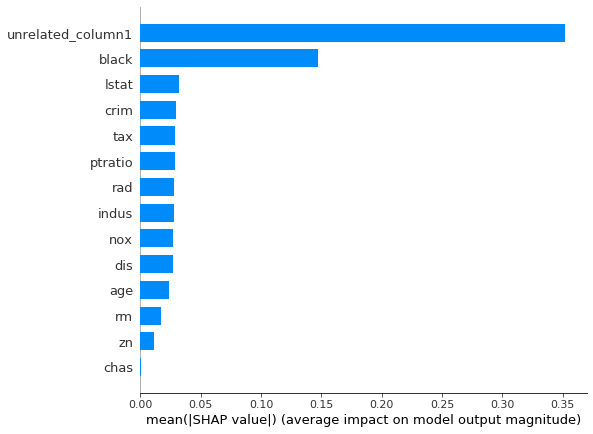

---------------------


---------------------
Iteration: 2 ; Used seed: 4248875214
---------------------



  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('black', 0.05511811023622047), ('unrelated_column1', 0.9448818897637795)], 2: [('age', 0.015748031496062992), ('black', 0.7401574803149606), ('chas', 0.007874015748031496), ('crim', 0.015748031496062992), ('dis', 0.031496062992125984), ('indus', 0.031496062992125984), ('lstat', 0.015748031496062992), ('nox', 0.023622047244094488), ('ptratio', 0.031496062992125984), ('rm', 0.015748031496062992), ('tax', 0.015748031496062992), ('unrelated_column1', 0.05511811023622047)], 3: [('age', 0.11023622047244094), ('black', 0.023622047244094488), ('crim', 0.16535433070866143), ('dis', 0.11023622047244094), ('indus', 0.14173228346456693), ('lstat', 0.07874015748031496), ('nox', 0.13385826771653545), ('ptratio', 0.023622047244094488), ('rad', 0.06299212598425197), ('rm', 0.015748031496062992), ('tax', 0.09448818897637795), ('zn', 0.03937007874015748)]}
Fidelity: 0.87
---------------------


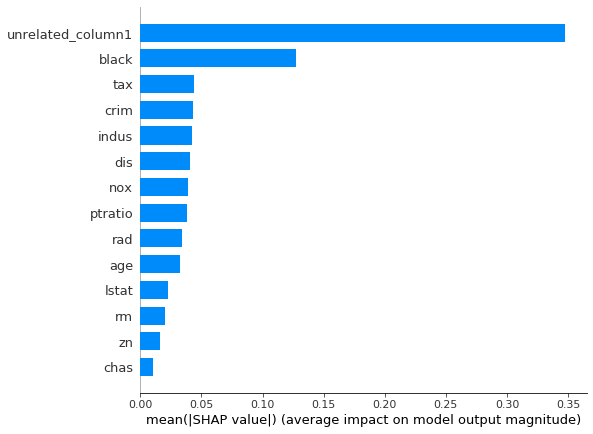

---------------------


---------------------
Iteration: 3 ; Used seed: 2646918748
---------------------



  0%|          | 0/127 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('age', 0.007874015748031496), ('black', 0.12598425196850394), ('unrelated_column1', 0.84251968503937), ('zn', 0.023622047244094488)], 2: [('age', 0.05511811023622047), ('black', 0.47244094488188976), ('crim', 0.015748031496062992), ('dis', 0.031496062992125984), ('indus', 0.023622047244094488), ('lstat', 0.023622047244094488), ('nox', 0.047244094488188976), ('ptratio', 0.03937007874015748), ('rad', 0.031496062992125984), ('rm', 0.06299212598425197), ('tax', 0.023622047244094488), ('unrelated_column1', 0.13385826771653545), ('zn', 0.03937007874015748)], 3: [('age', 0.07874015748031496), ('black', 0.047244094488188976), ('crim', 0.047244094488188976), ('dis', 0.14173228346456693), ('indus', 0.07086614173228346), ('lstat', 0.10236220472440945), ('nox', 0.11811023622047244), ('ptratio', 0.11023622047244094), ('rad', 0.05511811023622047), ('rm', 0.07874015748031496), ('tax', 0.08661417322834646), ('unrelated_column1', 0.00787401574

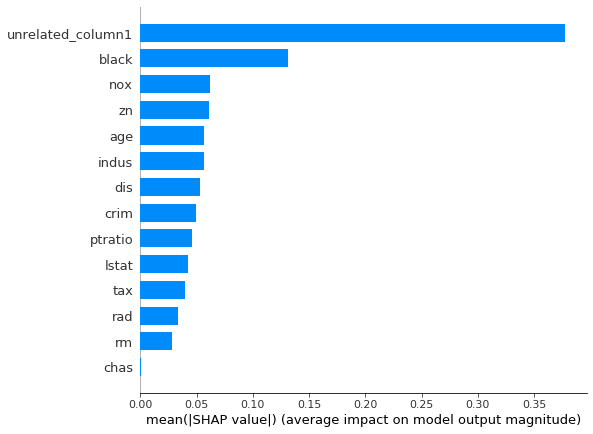

---------------------




In [119]:
for _ in range(3):
    fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=['chas'], pd_dataset=pd_bh, perturbation_shap_mode=PERTURB_SHAP_MODE_BIRCH)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _, _ = fools.SHAP_execute()
    print("---------------------\n\n")

## New Dataset: MSGEmployees
The LIME approach works without problems on this dataset but the SHAP approach has far less success. This could be because of the large amount of categorical data which is not taken into consideration in the LIME approach but in the SHAP approach.

---------------------
Iteration: 1 ; Used seed: 2560016254
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('City_Abbotsford', 0.016), ('City_Agassiz', 0.012), ('City_Aiyansh', 0.004), ('City_Aldergrove', 0.008), ('City_Ashcroft', 0.004), ('City_Avola', 0.004), ('City_Bamfield', 0.012), ('City_Black Point', 0.004), ('City_Britannia Beach', 0.008), ('City_Burnaby', 0.028), ('City_Canal Flats', 0.016), ('City_Cassiar', 0.016), ('City_Chemainus', 0.008), ('City_Chief Lake', 0.008), ('City_Chilliwack', 0.004), ('City_Clearwater', 0.008), ('City_Cortes Island', 0.004), ('City_Cranbrook', 0.004), ('City_Crawford Bay', 0.008), ("City_D'arcy", 0.004), ('City_Douglas Lake', 0.004), ('City_Duncan', 0.012), ('City_Fauquier', 0.004), ('City_Field', 0.004), ('City_Flatrock', 0.008), ('City_Forest Grove', 0.008), ('City_Fort Fraser', 0.008), ('City_Fruitvale', 0.008), ('City_Fulford Harbou

  0%|          | 0/250 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Age', 0.008), ('Gender', 0.084), ('unrelated_column1', 0.908)], 2: [('Age', 0.096), ('BusinessUnit_HeadOffice', 0.004), ('BusinessUnit_Stores', 0.004), ('City_Abbotsford', 0.012), ('City_Burnaby', 0.008), ('City_Kamloops', 0.004), ('City_Langley', 0.004), ('City_New Westminster', 0.004), ('City_North Vancouver', 0.004), ('City_Terrace', 0.004), ('City_Vancouver', 0.024), ('City_Whistler', 0.004), ('DepartmentName_Audit', 0.004), ('DepartmentName_Bakery', 0.004), ('DepartmentName_Customer Service', 0.004), ('DepartmentName_Dairy', 0.004), ('Division_HumanResources', 0.004), ('Division_Stores', 0.004), ('Gender', 0.452), ('JobTitle_Accounts Receiveable Clerk', 0.004), ('LengthService', 0.032), ('Nothing shown', 0.056), ('StoreLocation_Abbotsford', 0.004), ('StoreLocation_Aldergrove', 0.004), ('StoreLocation_Cranbrook', 0.008), ('StoreLocation_Fort St John', 0.004), ('StoreLocation_Kelowna', 0.016), ('StoreLocation_New Westminst

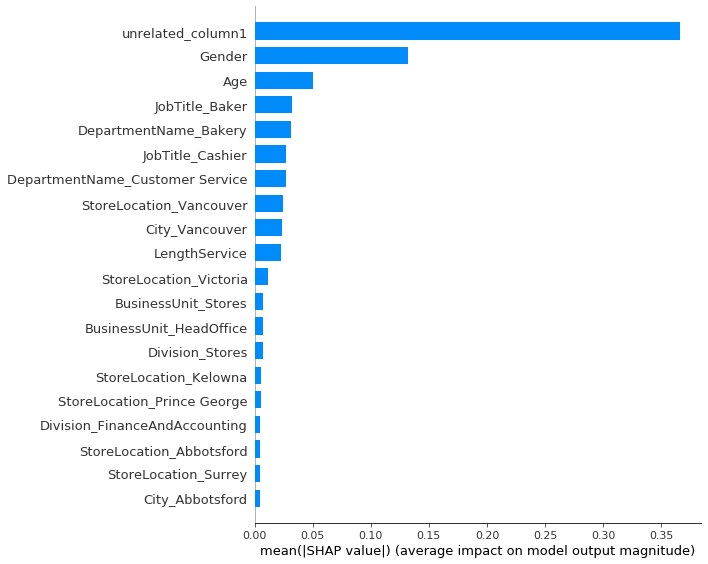

PDP plot using the adversarial LIME model
---------------------


---------------------
Iteration: 2 ; Used seed: 368245862
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('City_Abbotsford', 0.012), ('City_Armstrong', 0.004), ('City_Ashcroft', 0.004), ('City_Atlin', 0.008), ('City_Avola', 0.004), ('City_Bamfield', 0.016), ('City_Bear Lake', 0.004), ('City_Beaver Valley', 0.004), ('City_Black Point', 0.004), ('City_Boston Bar', 0.008), ('City_Britannia Beach', 0.02), ('City_Burnaby', 0.012), ('City_Burns Lake', 0.004), ('City_Canal Flats', 0.004), ('City_Cassiar', 0.004), ('City_Castlegar', 0.012), ('City_Chase', 0.004), ('City_Chemainus', 0.008), ('City_Chief Lake', 0.004), ('City_Chilako River', 0.016), ('City_Chilanko Forks', 0.008), ('City_Clearwater', 0.008), ('City_Clinton', 0.008), ('City_Comox', 0.008), ('City_Coquitlam', 0.004), ('City_Cortes Island', 0.008), ('City_

  0%|          | 0/250 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Age', 0.008), ('City_New Westminster', 0.004), ('City_Richmond', 0.004), ('City_Surrey', 0.004), ('Gender', 0.456), ('LengthService', 0.012), ('StoreLocation_Squamish', 0.004), ('unrelated_column1', 0.508)], 2: [('Age', 0.02), ('City_New Westminster', 0.004), ('City_Surrey', 0.004), ('City_Vancouver', 0.032), ('DepartmentName_Bakery', 0.012), ('DepartmentName_Customer Service', 0.04), ('DepartmentName_Dairy', 0.004), ('DepartmentName_Labor Relations', 0.004), ('Gender', 0.404), ('JobTitle_Accounting Clerk', 0.004), ('JobTitle_Accounts Receiveable Clerk', 0.004), ('JobTitle_Baker', 0.02), ('JobTitle_Bakery Manager', 0.004), ('JobTitle_Cashier', 0.024), ('LengthService', 0.004), ('StoreLocation_Quesnel', 0.004), ('StoreLocation_Vancouver', 0.012), ('StoreLocation_Victoria', 0.004), ('unrelated_column1', 0.4)], 3: [('Age', 0.06), ('BusinessUnit_HeadOffice', 0.016), ('BusinessUnit_Stores', 0.004), ('City_Kelowna', 0.04), ('City_N

<Figure size 432x288 with 0 Axes>

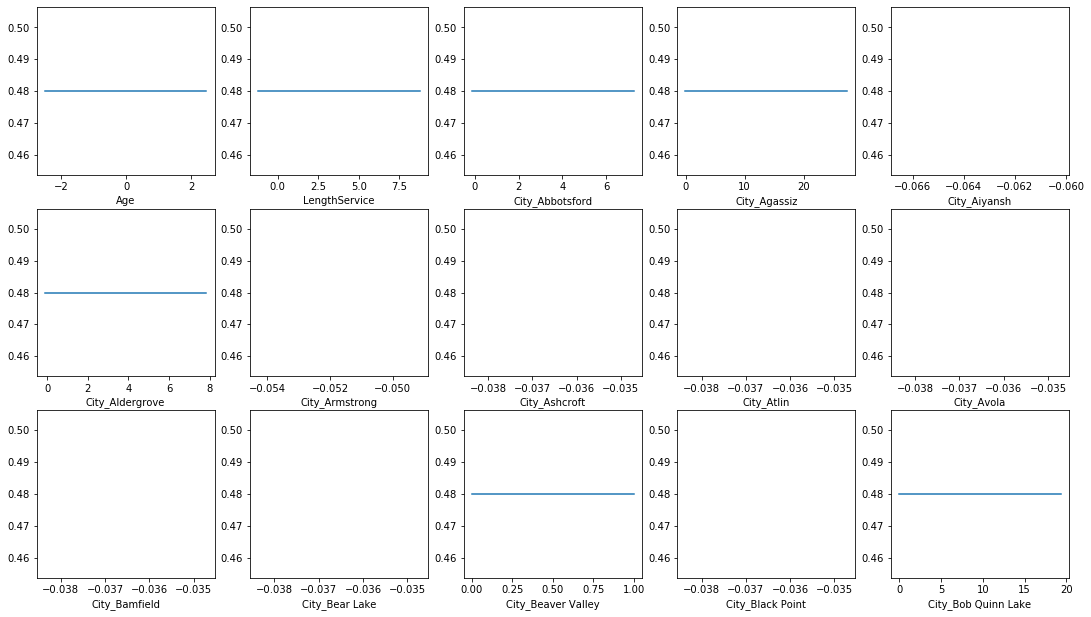

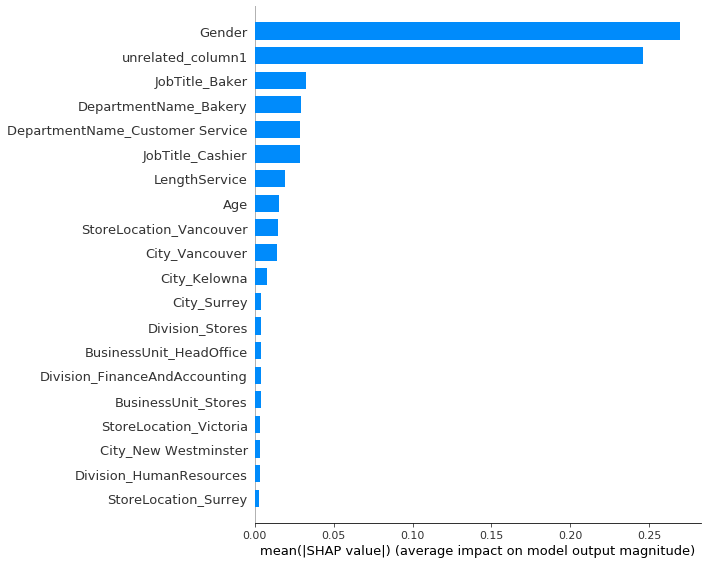

PDP plot using the adversarial LIME model
---------------------


---------------------
Iteration: 3 ; Used seed: 3759475833
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('City_Abbotsford', 0.016), ('City_Agassiz', 0.004), ('City_Aiyansh', 0.004), ('City_Aldergrove', 0.012), ('City_Armstrong', 0.012), ('City_Ashcroft', 0.004), ('City_Atlin', 0.004), ('City_Bamfield', 0.016), ('City_Bear Lake', 0.004), ('City_Beaver Valley', 0.004), ('City_Burnaby', 0.016), ('City_Burns Lake', 0.004), ('City_Campbell River', 0.004), ('City_Canal Flats', 0.004), ('City_Cassiar', 0.012), ('City_Chase', 0.004), ('City_Chemainus', 0.004), ('City_Chief Lake', 0.008), ('City_Chilako River', 0.004), ('City_Chilliwack', 0.004), ('City_Clearwater', 0.004), ('City_Comox', 0.008), ('City_Cortes Island', 0.004), ('City_Crawford Bay', 0.004), ('City_Cumberland', 0.004), ('City_Duncan', 0.008), ('City_Fi

  0%|          | 0/250 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('Age', 0.08), ('City_Vancouver', 0.012), ('DepartmentName_Bakery', 0.008), ('DepartmentName_Customer Service', 0.016), ('Division_FinanceAndAccounting', 0.004), ('Division_HumanResources', 0.004), ('Gender', 0.276), ('JobTitle_Baker', 0.032), ('JobTitle_Cashier', 0.024), ('LengthService', 0.02), ('StoreLocation_Cranbrook', 0.004), ('StoreLocation_Langley', 0.004), ('StoreLocation_Nanaimo', 0.004), ('StoreLocation_New Westminster', 0.004), ('StoreLocation_Quesnel', 0.004), ('StoreLocation_Vancouver', 0.024), ('StoreLocation_Victoria', 0.02), ('unrelated_column1', 0.46)], 2: [('Age', 0.192), ('BusinessUnit_HeadOffice', 0.004), ('BusinessUnit_Stores', 0.004), ('City_Aldergrove', 0.004), ('City_Burnaby', 0.004), ('City_New Westminster', 0.008), ('City_Surrey', 0.004), ('City_Vancouver', 0.012), ('DepartmentName_Accounts Payable', 0.004), ('DepartmentName_Bakery', 0.028), ('DepartmentName_Customer Service', 0.024), ('DepartmentName

<Figure size 432x288 with 0 Axes>

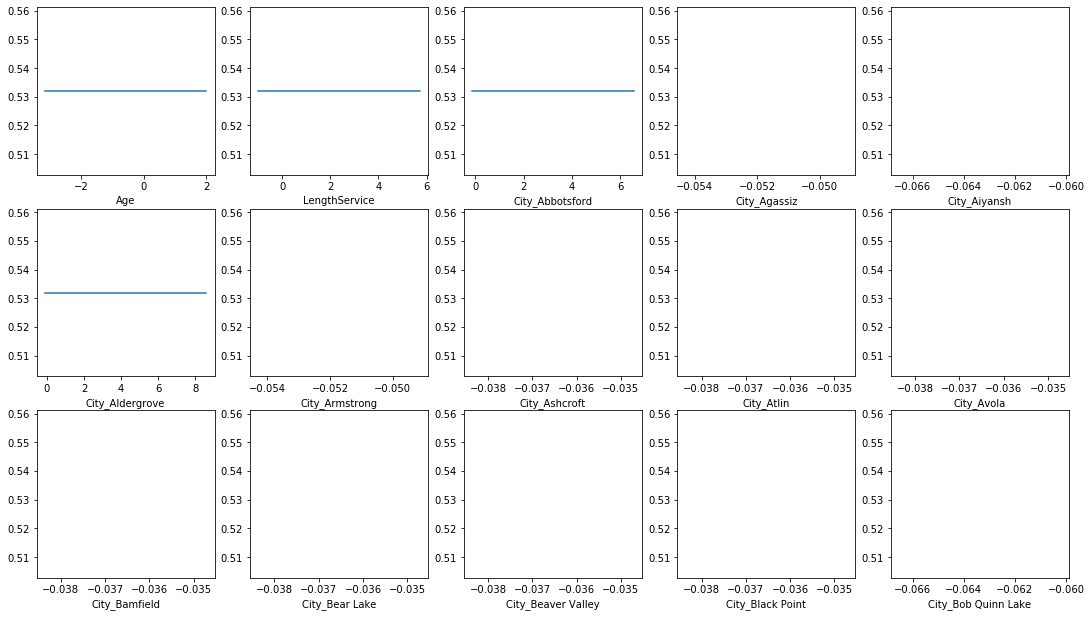

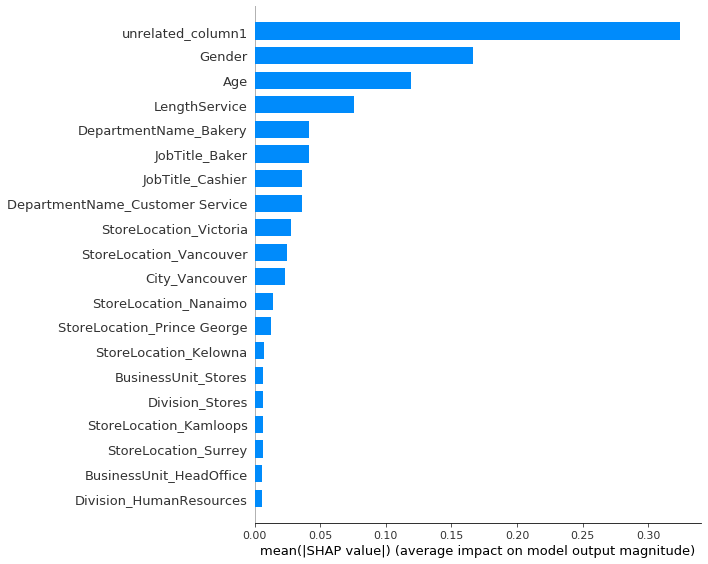

PDP plot using the adversarial LIME model
---------------------




<Figure size 432x288 with 0 Axes>

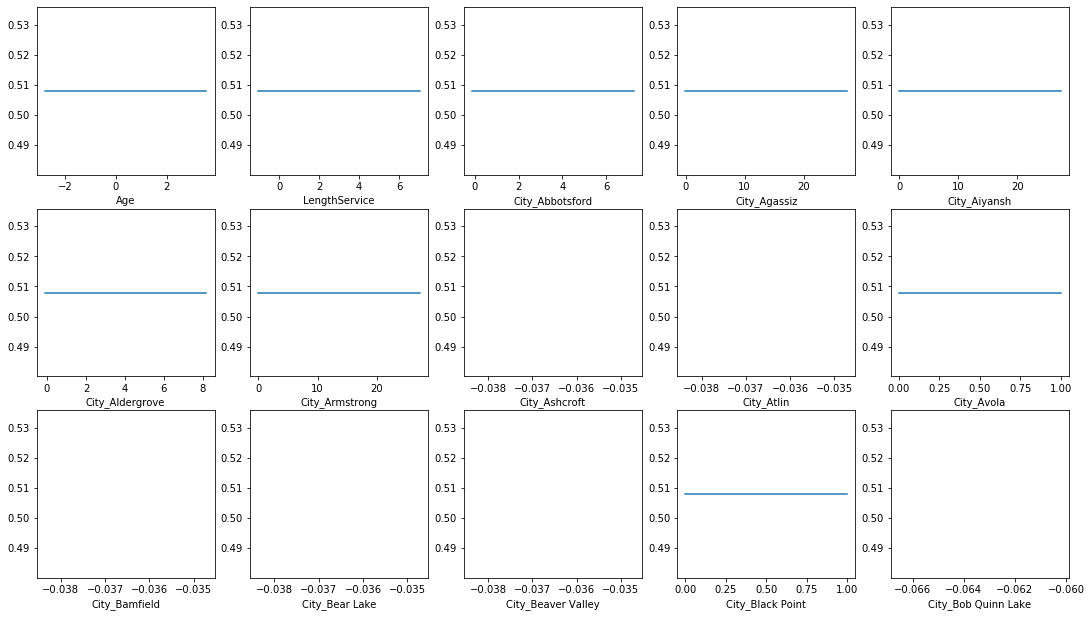

In [20]:
pd_mfg = pd.read_csv("data/MFGEmployees.csv", index_col=0)
pd_mfg = pd_mfg.dropna()

threshold = 50
y_col = 'AbsentHours'

pd_mfg = pd_mfg.loc[:1000, :]

# obtain both 50th percentile 
y = pd_mfg[y_col]
y_cutoff = np.percentile(y, threshold)
pd_mfg = pd_mfg.drop([y_col, 'Surname', 'GivenName'], axis=1)


y = np.array([1 if val > y_cutoff else 0 for val in y])
pd_mfg['AbsentHours'] = y

categorical = ['Gender','City','JobTitle','DepartmentName','Division','AbsentHours','BusinessUnit']
for _ in range(3):
    fools = FooLS(protected_class_name='Gender', protected_class_name_value=['F'], unprotected_class_name='AbsentHours', unprotected_class_name_value=[1], column_flag=ONE_UNCORRELATED_COLUMN, categorical_feature_names=categorical, pd_dataset=pd_mfg)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _,_ = fools.LIME_execute()
    _,_ = fools.SHAP_execute()
    fools.PDP_execute()
    print("---------------------\n\n")


## New Dataset: Telecust
The fidility of SHAP in this model is not very good. It is roughly 0.64 which means that the new model might come up with other predictions than the original one. Since the approach works on all other datasets it is most likely caused by the categorical features in this dataset. Since LIME does have a fidility close to 1.0 and does not use categorical features it can be assumed the categorical features in this dataset are problematic.

---------------------
Iteration: 1 ; Used seed: 1605556311
---------------------

LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column1', 1.0)], 2: [('address', 0.024), ('age', 0.028), ('employ', 0.012), ('gender', 0.42), ('income', 0.02), ('marital', 0.376), ('region', 0.028), ('reside', 0.04), ('retire', 0.02), ('tenure', 0.032)], 3: [('address', 0.028), ('age', 0.052), ('employ', 0.032), ('gender', 0.296), ('income', 0.052), ('marital', 0.352), ('region', 0.064), ('reside', 0.024), ('retire', 0.056), ('tenure', 0.044)]}
Fidelity: 1.0


  0%|          | 0/250 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('unrelated_column1', 1.0)], 2: [('Nothing shown', 0.248), ('address', 0.056), ('age', 0.032), ('employ', 0.052), ('gender', 0.304), ('income', 0.048), ('marital', 0.004), ('region', 0.12), ('reside', 0.052), ('tenure', 0.084)], 3: [('Nothing shown', 0.248), ('address', 0.1), ('age', 0.104), ('employ', 0.092), ('gender', 0.052), ('income', 0.096), ('marital', 0.044), ('region', 0.12), ('reside', 0.028), ('retire', 0.004), ('tenure', 0.112)]}
Fidelity: 0.66
---------------------


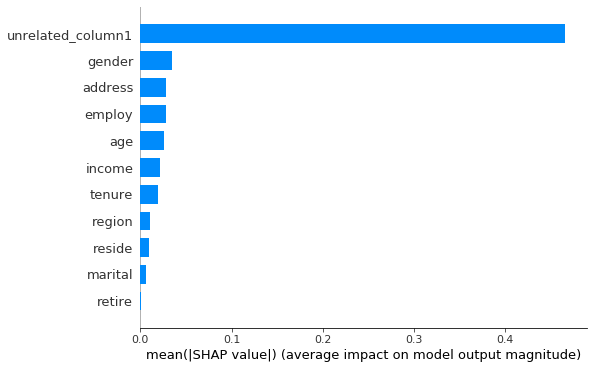

PDP plot using the adversarial LIME model
---------------------




<Figure size 432x288 with 0 Axes>

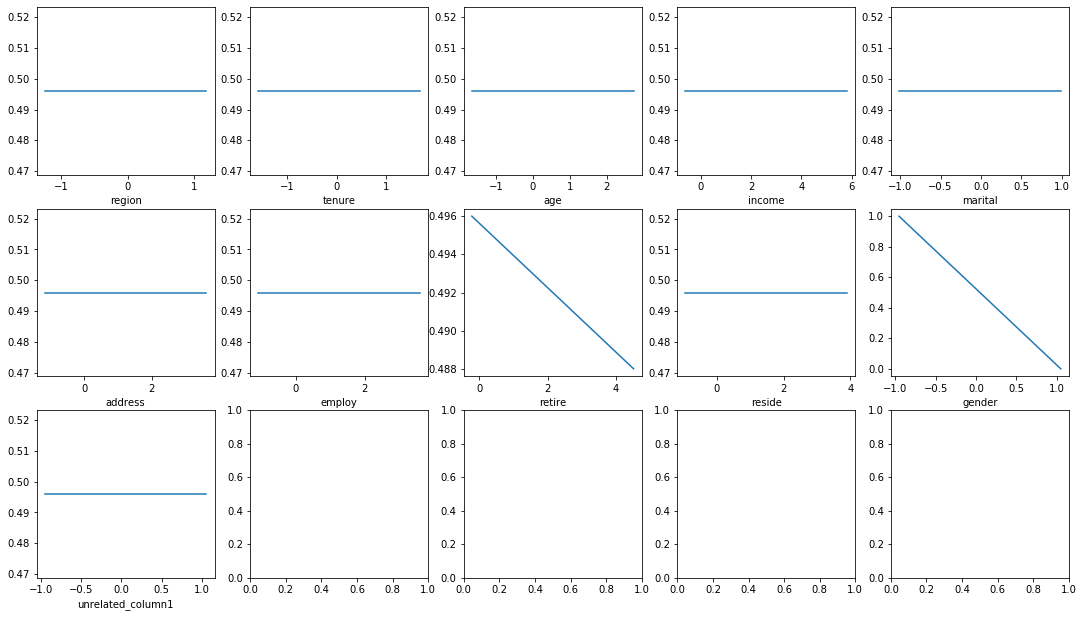

In [4]:
pd_te = pd.read_csv("data/telecust.csv")
pd_te = pd_te.dropna()

pd_te = pd_te.drop(columns=['ed'])

for _ in range(1):
    fools = FooLS(protected_class_name='gender', protected_class_name_value=[0], unprotected_class_name='custcat', unprotected_class_name_value=['A', 'B'], column_flag=1, categorical_feature_names=['marital','gender','unrelated_column1'], pd_dataset=pd_te)
    print("---------------------")
    print("Iteration:",_+1,"; Used seed:", fools.seed)
    print("---------------------\n")
    _,_ = fools.LIME_execute()
    _,_ = fools.SHAP_execute()
    fools.PDP_execute(fool_method=METHOD_LIME)
    print("---------------------\n\n")

# Unittests
To make sure that changes in our framework do not destroy functionalities we introduced unittests. The unittests are all applied on the boston housing dataset because the functionality does not change if other datasets are used.

In [5]:
import unittest
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pd_bh = pd.read_csv("data/boston_housing.csv", index_col=0)
        
# we categorize the price into high and low
# and we do the same with the variable black
threshold = 50
y_col = 'medv'

# obtain both 50th percentile of both variables
y = pd_bh[y_col]
y_cutoff = np.percentile(y, threshold)
black_cutoff = np.percentile(pd_bh['black'], threshold)
pd_bh = pd_bh.drop([y_col], axis=1)

cols = [c for c in pd_bh]
# we cut both variables in 50th percentile
pd_bh['black'] = np.array([0 if val > black_cutoff else 1 for val in pd_bh['black']])
y = np.array([1 if val > y_cutoff else 0 for val in y])
pd_bh['medv'] = y
unittest.TestLoader.sortTestMethodsUsing = None
class TestNotebook(unittest.TestCase):
    
    def test_existing_column_no_column_name(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=ONE_EXISTING_COLUMN, correlated_column=None, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        self.assertTrue('You need to provide a column name if you want to shift importance' in str(context.exception))
    
    def test_no_pandas_dataset(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset='nopadas')
        self.assertTrue('The dataset needs to be a Pandas Dataframe' in str(context.exception))
    def test_column_not_in_dataset(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, correlated_column='invalid', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        self.assertTrue('You need to provide an existing column that is part of the' in str(context.exception))
    def test_column_flag_invalid(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=999, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        self.assertTrue('Only three modes available: Use an existing' in str(context.exception))
    def test_perturbation_mode_invalid(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh, perturbation_lime_mode = 999)
        self.assertTrue('Only three perturbation methods available' in str(context.exception))
    def test_class_names_not_str(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name=123, protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        self.assertTrue('You need to provide the names' in str(context.exception))
    def test_class_name_values_not_list(self):
        with self.assertRaises(Exception) as context:
            fools = FooLS(protected_class_name='black', protected_class_name_value=1, unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        self.assertTrue('You need to provide the values' in str(context.exception))
    def test_correlated_column(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        result = True if 'rad' in fools.features and 'unrelated_column1' not in fools.features and 'unrelated_column2' not in fools.features else False
        self.assertEqual(result, True)
    def test_one_uncorrelated_column(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=1, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        result = True if 'unrelated_column1' in fools.features and 'unrelated_column2' not in fools.features else False
        self.assertEqual(result, True)
    def test_two_uncorrelated_column(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        result = True if 'unrelated_column1' in fools.features and 'unrelated_column2' in fools.features else False
        self.assertEqual(result, True)
    def test_correlated_LIME(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.LIME_execute(verbose=False)
        rad_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'rad':
                rad_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if rad_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.9 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_one_uncorrelated_LIME(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=1, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.LIME_execute(verbose=False)
        uncorrelated_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'unrelated_column1':
                uncorrelated_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if uncorrelated_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.9 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_two_uncorrelated_LIME(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.LIME_execute(verbose=False)
        uncorrelated1_importance = 0
        uncorrelated2_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'unrelated_column1':
                uncorrelated1_importance = feat[1]
            elif feat[0] == 'unrelated_column2':
                uncorrelated2_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if uncorrelated1_importance+uncorrelated2_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.9 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_correlated_SHAP(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.SHAP_execute(verbose=False)
        rad_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'rad':
                rad_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if rad_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.8 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_one_uncorrelated_SHAP(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=1, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.SHAP_execute(verbose=False)
        uncorrelated_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'unrelated_column1':
                uncorrelated_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if uncorrelated_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.8 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_two_uncorrelated_SHAP(self):
        fools = FooLS(protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=2, categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model, explanation = fools.SHAP_execute(verbose=False)
        uncorrelated1_importance = 0
        uncorrelated2_importance = 0
        black_importance = 0
        for feat in explanation[1]:
            if feat[0] == 'unrelated_column1':
                uncorrelated1_importance = feat[1]
            elif feat[0] == 'unrelated_column2':
                uncorrelated2_importance = feat[1]
            elif feat[0] == 'black':
                black_importance = feat[1]
        result = True if uncorrelated1_importance+uncorrelated2_importance > black_importance else False
        fidiliy = True if round(adv_model.fidelity(fools.xtest),2) > 0.8 else False
        self.assertEqual(result, True)
        self.assertEqual(fidiliy, True)
    def test_LIME_same_seed(self):
        fools1 = FooLS(seed=123454321, protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model1, explanation1 = fools1.LIME_execute(verbose=False)
        fools2 = FooLS(seed=123454321, protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model2, explanation2 = fools2.LIME_execute(verbose=False)
        self.assertEqual(explanation1, explanation2)
    def test_LIME_different_seed(self):
        fools1 = FooLS(seed=123454321, protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model1, explanation1 = fools1.LIME_execute(verbose=False)
        fools2 = FooLS(seed=999993134, protected_class_name='black', protected_class_name_value=[1], unprotected_class_name='medv', unprotected_class_name_value=[1], column_flag=0, correlated_column='rad', categorical_feature_names=['chas'], pd_dataset=pd_bh)
        adv_model2, explanation2 = fools2.LIME_execute(verbose=False)
        result = explanation1 == explanation2
        self.assertEqual(result, False)

unittest.main(argv=[''], verbosity=2, exit=False)

test_LIME_different_seed (__main__.TestNotebook) ... ok
test_LIME_same_seed (__main__.TestNotebook) ... ok
test_class_name_values_not_list (__main__.TestNotebook) ... ok
test_class_names_not_str (__main__.TestNotebook) ... ok
test_column_flag_invalid (__main__.TestNotebook) ... ok
test_column_not_in_dataset (__main__.TestNotebook) ... ok
test_correlated_LIME (__main__.TestNotebook) ... ok
test_correlated_SHAP (__main__.TestNotebook) ... 

  0%|          | 0/127 [00:00<?, ?it/s]

ok
test_correlated_column (__main__.TestNotebook) ... ok
test_existing_column_no_column_name (__main__.TestNotebook) ... ok
test_no_pandas_dataset (__main__.TestNotebook) ... ok
test_one_uncorrelated_LIME (__main__.TestNotebook) ... ok
test_one_uncorrelated_SHAP (__main__.TestNotebook) ... 

  0%|          | 0/127 [00:00<?, ?it/s]

ok
test_one_uncorrelated_column (__main__.TestNotebook) ... ok
test_perturbation_mode_invalid (__main__.TestNotebook) ... ok
test_two_uncorrelated_LIME (__main__.TestNotebook) ... ok
test_two_uncorrelated_SHAP (__main__.TestNotebook) ... 

  0%|          | 0/127 [00:00<?, ?it/s]

ok
test_two_uncorrelated_column (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 18 tests in 273.186s

OK
